### Load Packages and Data

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import shap


# import seaborn as sns
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import cross_val_score, KFold


# the below extension properly formats a cell after it is run
%load_ext nb_black

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [219]:
# Load Data
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [220]:
housing.shape

(2558, 65)

<IPython.core.display.Javascript object>

In [221]:
# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

In [222]:
housing.Neighborhood.unique()

array(['SWISU', 'Edwards', 'IDOTRR', 'OldTown', 'NWAmes', 'Blmngtn',
       'Mitchel', 'NridgHt', 'NAmes', 'CollgCr', 'SawyerW', 'MeadowV',
       'BrDale', 'Gilbert', 'Timber', 'Somerst', 'BrkSide', 'NoRidge',
       'Sawyer', 'Crawfor', 'Greens', 'ClearCr', 'StoneBr', 'Veenker',
       'NPkVill', 'Blueste'], dtype=object)

<IPython.core.display.Javascript object>

In [223]:
# # define the mapping for the Neighborhood feature

# Neighborhood_mapping = {
#     "SWISU": 0,
#     "Edwards": 1,
#     "IDOTRR": 2,
#     "OldTown": 3,
#     "NWAmes": 4,
#     "Blmngtn": 5,
#     "Mitchel": 6,
#     "NridgHt": 7,
#     "NAmes": 8,
#     "CollgCr": 9,
#     "SawyerW": 10,
#     "MeadowV": 11,
#     "BrDale": 12,
#     "Gilbert": 13,
#     "Timber": 14,
#     "Somerst": 15,
#     "BrkSide": 16,
#     "NoRidge": 17,
#     "Sawyer": 18,
#     "Crawfor": 19,
#     "Greens": 20,
#     "ClearCr": 21,
#     "StoneBr": 22,
#     "Veenker": 23,
#     "NPkVill": 24,
#     "Blueste": 25,
# }

<IPython.core.display.Javascript object>

### Ordinal encoding data

In [227]:
# get a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)

# create an instance of the OrdinalEncoder class
ordinal_encoder = OrdinalEncoder()

# fit the ordinal encoder to the categorical features
ordinal_encoder.fit(housing[cat_features])

# transform the categorical features into encoded numerical values
housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

## Train Test Split

In [8]:
X = housing.loc[:, housing.columns != "SalePrice"]
y = housing.loc[:, "SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2,
)

<IPython.core.display.Javascript object>

In [9]:
print(X_train.shape)
print(X_test.shape)

(2046, 62)
(512, 62)


<IPython.core.display.Javascript object>

### Model Scoring Function

In [11]:
def r2mae_scores(model, X, y, cv=5):
    """
    Calculate R^2 and Mean Absolute Error (MAE) scores for the given model using cross-validation.
    
    Args:
        model: A scikit-learn model
        X: The feature matrix (numpy array or pandas DataFrame)
        y: The target variable (numpy array or pandas Series)
        cv: Number of folds for cross-validation (default: 5)

    Returns:
        avg_r2_score: The average R^2 score across the cross-validation folds
        avg_MAE_score: The average MAE score across the cross-validation folds
    """

    # Using R^2 as the scoring metric
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring="r2", n_jobs=-1)

    # Using Mean Absolute Error as the scoring metric
    mae_scores = cross_val_score(
        model, X, y, cv=cv, scoring="neg_mean_absolute_error", n_jobs=-1
    )

    # Convert the MAE scores back to positive
    mae_scores = -1 * mae_scores

    avg_r2_score = np.mean(r2_scores)
    avg_MAE_score = np.mean(mae_scores)

    return avg_r2_score, avg_MAE_score


def print_scores(avg_r2_score, avg_MAE_score):
    """
    Print the average R^2 and MAE scores.

    Args:
        avg_r2_score: The average R^2 score
        avg_MAE_score: The average MAE score
    """
    print("-" * 50)
    print("5-fold Cross Validation Scoring")
    print("Average R^2 score:", avg_r2_score)
    print("Average MAE score:", avg_MAE_score)
    print("-" * 50)

<IPython.core.display.Javascript object>

### Random Tree Regression

In [12]:
model = ensemble.RandomForestRegressor(random_state=0)
avg_r2_score, avg_MAE_score = r2mae_scores(model, X_train, y_train)
print_scores(avg_r2_score, avg_MAE_score)

--------------------------------------------------
5-fold Cross Validation Scoring
Average R^2 score: 0.8962459717714694
Average MAE score: 14961.556414693212
--------------------------------------------------


<IPython.core.display.Javascript object>

### Feature Selection and Optimizing Number of Features

In [21]:
# from sklearn.model_selection import cross_val_score

np.random.seed(42)


def feature_importance(model, X, y):
    model.fit(X, y)
    return sorted(
        zip(X.columns, model.feature_importances_), key=lambda t: t[1], reverse=True
    )


def r2_score_by_feature_count(model, X_train, y_train, X_test, y_test):
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features]

    scores = []
    for i in range(len(selected_columns)):
        X_train_subset = X_train[selected_columns[: i + 1]]
        X_test_subset = X_test[selected_columns[: i + 1]]

        model.fit(X_train_subset, y_train)
        score = cross_val_score(
            model, X_test_subset, y_test, cv=5, scoring="r2", n_jobs=-1
        )
        scores.append((i, np.mean(score)))

    return scores


def plot_scores(scores, vline_val):
    x_values = [t[0] for t in scores]
    y_values = [t[1] for t in scores]

    plt.plot(x_values, y_values)
    plt.axvline(x=vline_val, color="red", linestyle="--", alpha=0.4)

    plt.xlabel("# of Features")
    plt.ylabel("R^2 Performance")
    plt.title("Feature Selection")

    plt.show()

<IPython.core.display.Javascript object>

In [23]:
model = RandomForestRegressor(random_state=0)
scores = r2_score_by_feature_count(model, X_train, y_train, X_test, y_test)

<IPython.core.display.Javascript object>

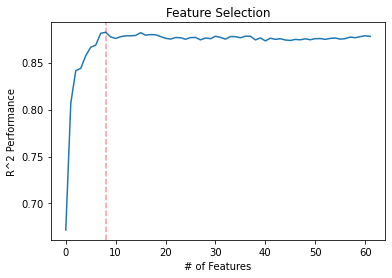

<IPython.core.display.Javascript object>

In [33]:
plot_scores(scores=scores, vline_val=8)

Optimal number of features is 8

In [34]:
def plot_feature_importance(model, X_train, n_features=35):
    sorted_importance = sorted(
        zip(X_train.columns, model.feature_importances_),
        key=lambda t: t[1],
        reverse=True,
    )

    # Get data for the plot (n_features based on your preference)
    a, b = zip(*sorted_importance[:n_features])
    df = pd.DataFrame({"feature_name": a, "importance_score": b})

    # Plot
    plt.figure(figsize=(20, 10))
    df.plot.bar(x="feature_name", y="importance_score", legend=None)
    plt.title("Feature Importance")
    plt.show()

<IPython.core.display.Javascript object>

In [35]:
random_forest_model = RandomForestRegressor(random_state=0)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

<IPython.core.display.Javascript object>

<Figure size 1440x720 with 0 Axes>

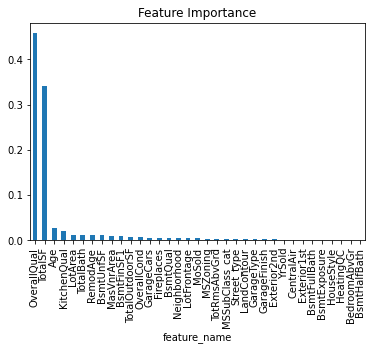

<IPython.core.display.Javascript object>

In [36]:
plot_feature_importance(random_forest_model, X_train, n_features=35)

## Comparing Models of Optimal Features Vs All Features

In [37]:
def compare_models(model, X_train, y_train, X_test, y_test, optimal_features_count):
    # All features
    model.fit(X_train, y_train)
    all_features_score = model.score(X_test, y_test)

    # Optimal features
    sorted_features = feature_importance(model, X_train, y_train)
    selected_columns = [col for col, _ in sorted_features][:optimal_features_count]

    X_train_optimal = X_train[selected_columns]
    X_test_optimal = X_test[selected_columns]

    model.fit(X_train_optimal, y_train)
    optimal_features_score = model.score(X_test_optimal, y_test)

    return all_features_score, optimal_features_score

<IPython.core.display.Javascript object>

In [39]:
model = RandomForestRegressor(random_state=0)
optimal_features_count = 8  # This from the plot_scores function
all_features_score, optimal_features_score = compare_models(
    model, X_train, y_train, X_test, y_test, optimal_features_count
)

print("R^2 score using all features: ", all_features_score)
print("R^2 score using optimal features: ", optimal_features_score)

R^2 score using all features:  0.9101409579414029
R^2 score using optimal features:  0.9023765335436023


<IPython.core.display.Javascript object>

The scores show that using all features is best and this is also what the plot shows

## Checking for Overfitting by Looking at the Train and Test Errors

In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the train and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the mean squared error for the train and test sets
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Calculate the R^2 for the train and test sets
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print("The training error (MSE) is: %.5f" % mse_train)
    print("The test     error (MSE) is: %.5f" % mse_test)
    print("The training R^2 is: %.5f" % r2_train)
    print("The test     R^2 is: %.5f" % r2_test)

<IPython.core.display.Javascript object>

In [42]:
random_forest_model = RandomForestRegressor(random_state=0)
evaluate_model(random_forest_model, X_train, y_train, X_test, y_test)

The training error (MSE) is: 84864780.89919
The test     error (MSE) is: 532073046.11335
The training R^2 is: 0.98464
The test     R^2 is: 0.91014


<IPython.core.display.Javascript object>

Model is overfitting

# Tuning the Hyper Parameters

In [43]:
from sklearn.model_selection import RandomizedSearchCV

def find_best_params(X_train, y_train):
    param_grid = {
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }

    rf = RandomForestRegressor(random_state=0)
    randomized_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error', random_state=0)

    randomized_search.fit(X_train, y_train)

    return randomized_search.best_params_

best_params = find_best_params(X_train, y_train)
print("Best parameters found by RandomizedSearchCV:")
print(best_params)

best_rf = RandomForestRegressor(**best_params, random_state=0)
evaluate_model(best_rf, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found by RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None}
The training error (MSE) is: 112563491.41202
The test     error (MSE) is: 528491646.33996
The training R^2 is: 0.97963
The test     R^2 is: 0.91075


<IPython.core.display.Javascript object>

# Using Shap to look at the features that contributed the most to the SalePrice

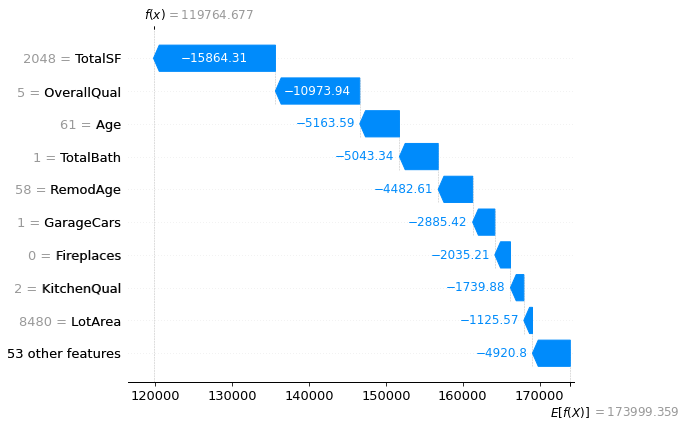

<IPython.core.display.Javascript object>

In [44]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the first instance in the dataset
instance_index = 0

# Get the SHAP values for the specified instance in X_train
shap_values_instance = explainer(X_train.iloc[instance_index : instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the instance
# A waterfall plot helps visualize the contribution of each feature to the final prediction for the instance
shap.plots.waterfall(shap_values_instance[0])

## SHAP for total bathrooms

 99%|===================| 2020/2046 [01:17<00:00]        

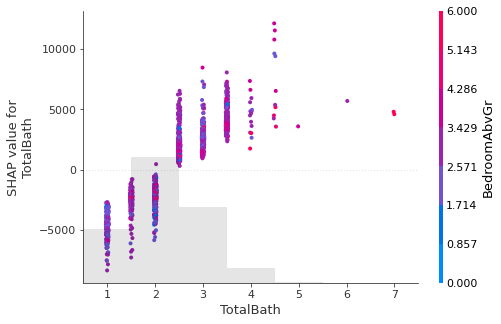

<IPython.core.display.Javascript object>

In [48]:
# Looking at the interaction of total bathrooms and total bedrooms

# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Plot the interaction between TotalBath and BedroomAbvGr
shap.plots.scatter(shap_values[:, "TotalBath"], color=shap_values[:, "BedroomAbvGr"])

plt.show()

It looks like there are a few plots where the value in TotalBath contributes to more than $10,0000
of the saleprice

In [49]:
# Finding indices of observations with a SHAP value for TotalBath greater than 10000
high_shap_indices = np.where(shap_values[:, X_train.columns.get_loc("TotalBath")].values > 10000)[0]

print("Indices of observations with high SHAP values for TotalBath:", high_shap_indices)


Indices of observations with high SHAP values for TotalBath: [ 168  995 1913]


<IPython.core.display.Javascript object>

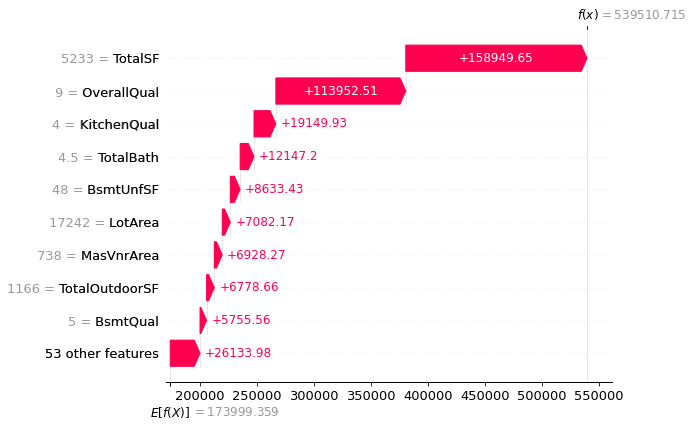

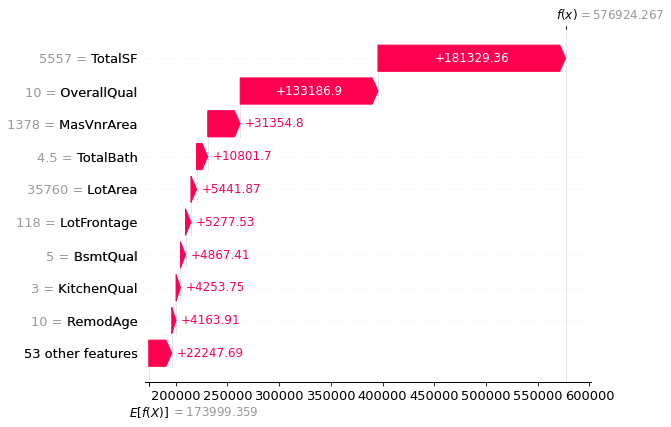

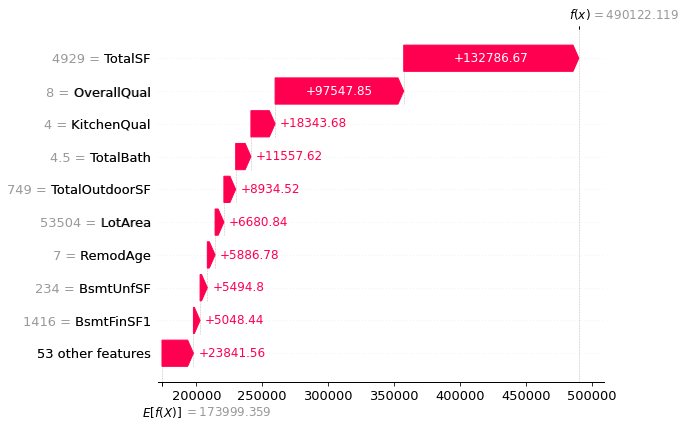

<IPython.core.display.Javascript object>

In [50]:
# Plot the SHAP values as a waterfall plot for each high-value observation
for index in high_shap_indices:
    shap_values_instance = explainer(X_train.iloc[index:index + 1, :])
    shap.plots.waterfall(shap_values_instance[0])
    plt.show()


100%|===================| 2044/2046 [01:18<00:00]        

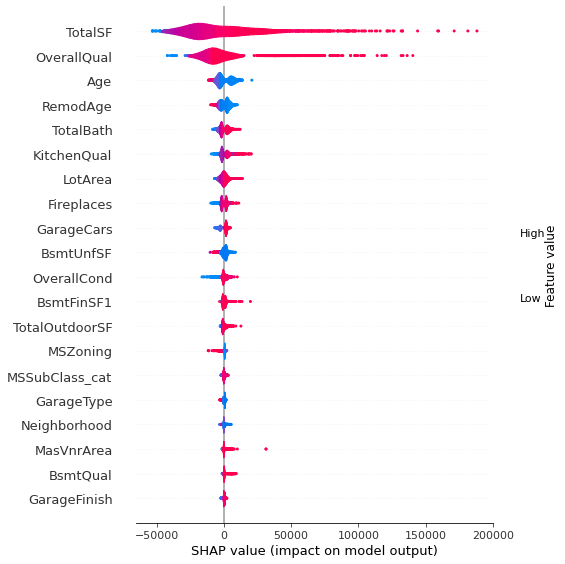

<IPython.core.display.Javascript object>

In [51]:
# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Get the base value (expected value) from the explainer
base_value = shap_values.base_values

# Set the expected_value attribute for the SHAP values
shap_values.expected_value = base_value

# Plot the SHAP violin plot for all features
shap.plots.violin(shap_values)



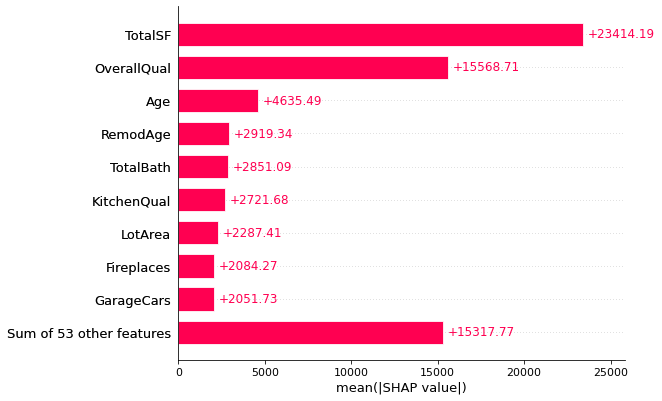

<IPython.core.display.Javascript object>

In [52]:
shap.plots.bar(shap_values)

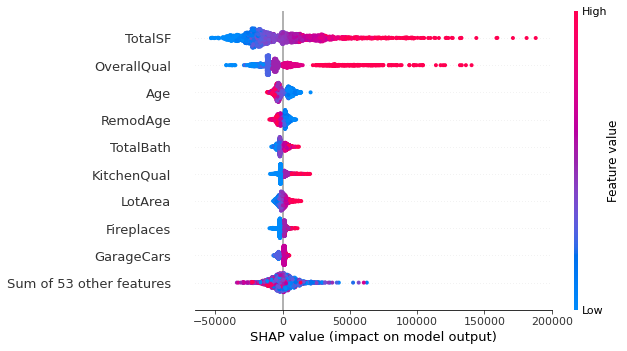

<IPython.core.display.Javascript object>

In [53]:
shap.plots.beeswarm(shap_values)

Using the explainer that was created above I will now try to answer a few questions

## SHAP for KitchQual

 99%|===================| 2021/2046 [01:17<00:00]        

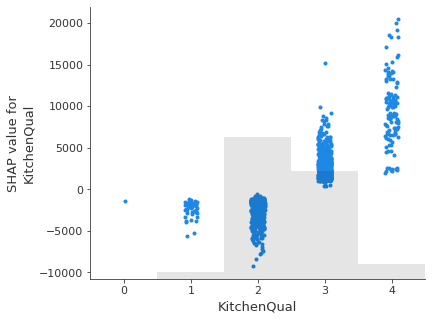

<IPython.core.display.Javascript object>

In [57]:
# Looking at the interaction of total bathrooms and total bedrooms

# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Plot the interaction between TotalBath and BedroomAbvGr
shap.plots.scatter(shap_values[:, "KitchenQual"])

plt.show()

In [67]:
X_train.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageFinish', 'GarageCars', 'GarageQual', 'PavedDrive', 'Fence',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'Age', 'RemodAge',
       'TotalSF', 'Remodeled', 'TotalBath', 'MSSubClass_cat', 'Street_type',
       'TotalOutdoorSF'],
      dtype='object')

<IPython.core.display.Javascript object>

Indices of observations with high SHAP values for TotalBath: [   9   66   84   85  134  139  158  168  170  190  266  340  363  365
  420  560  572  576  710  778  813  822  834  855  887  890  917  931
  936 1020 1067 1103 1136 1154 1169 1201 1202 1246 1315 1347 1399 1409
 1419 1784 1804 1861 1911 1913 1949 2035 2037]


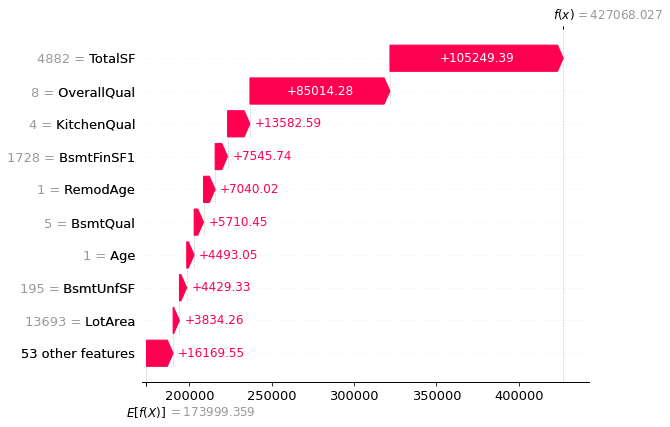

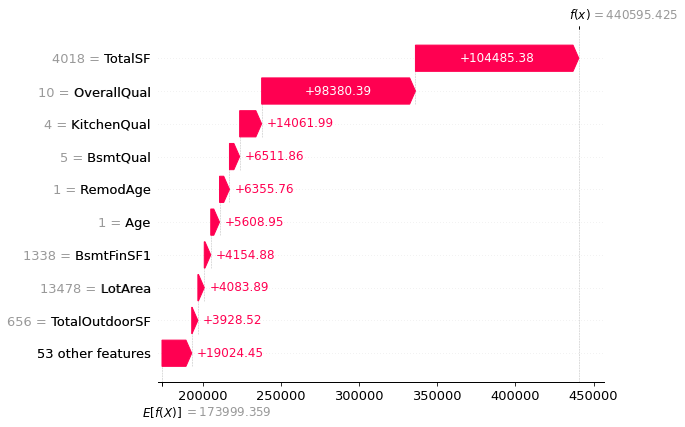

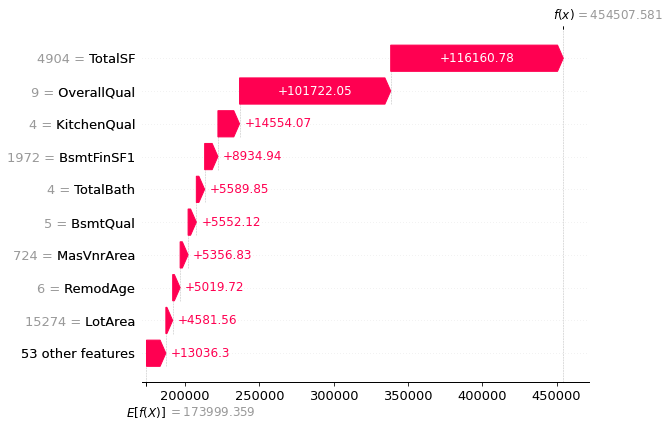

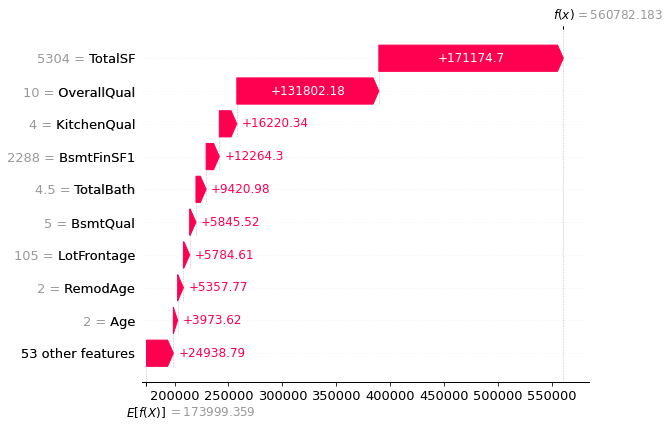

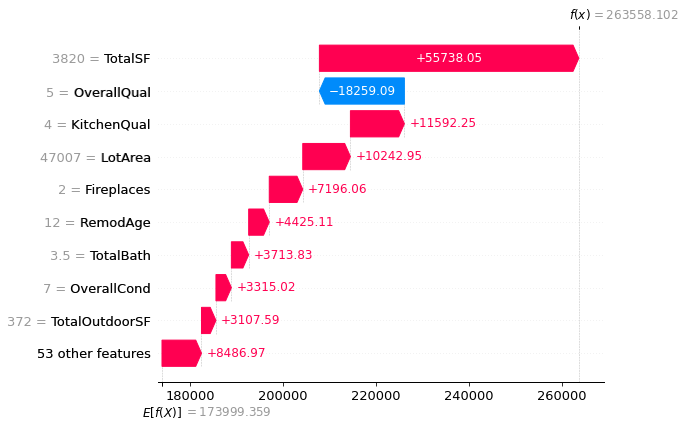

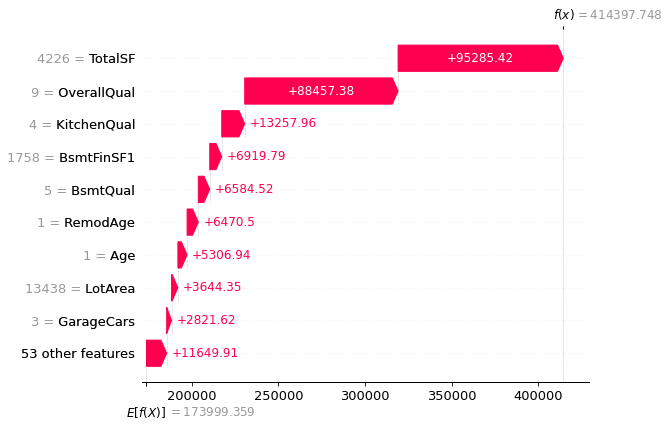

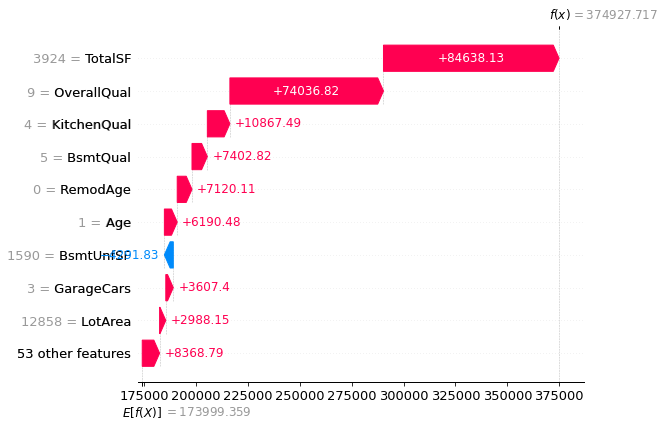

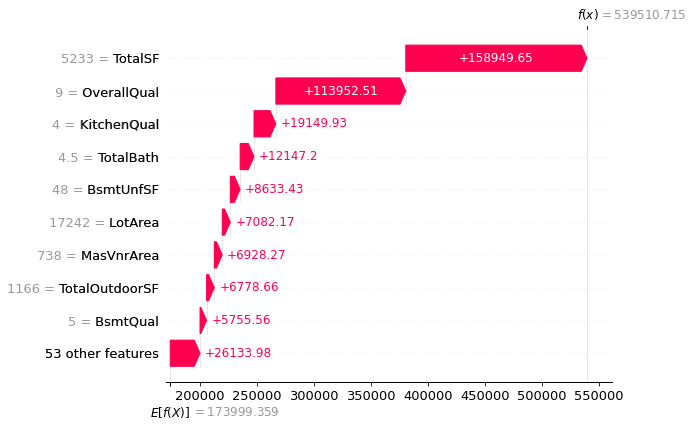

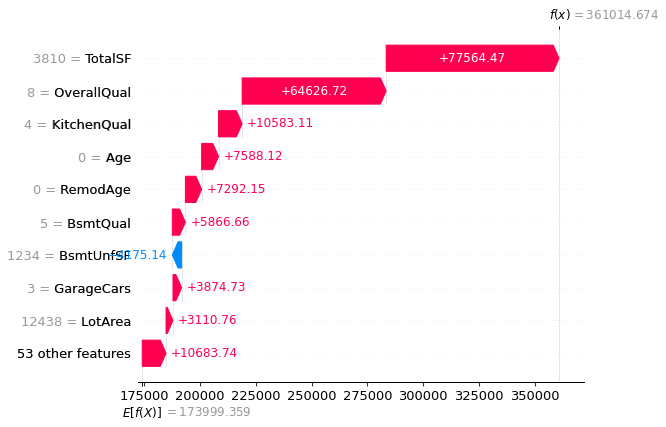

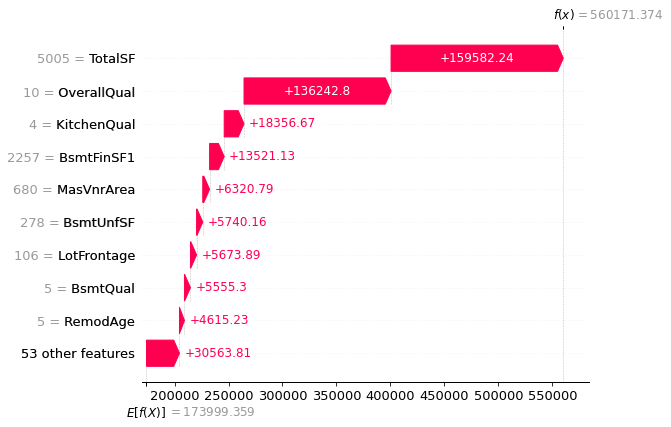

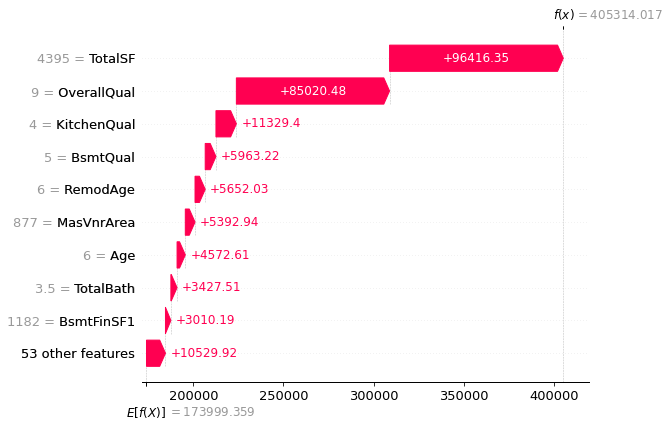

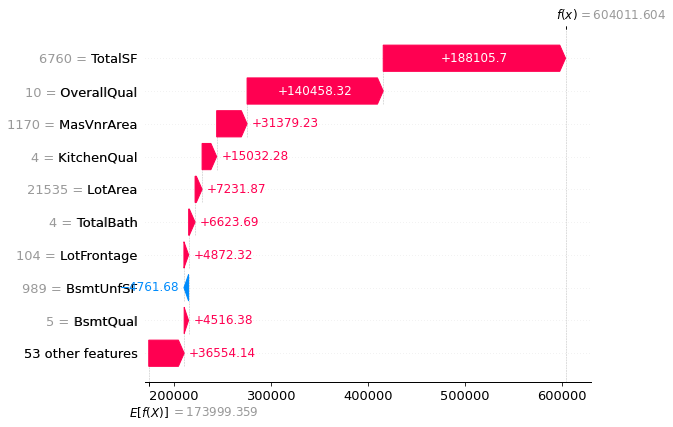

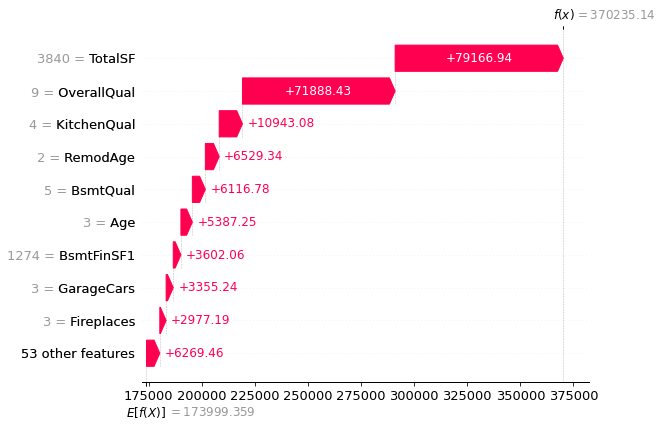

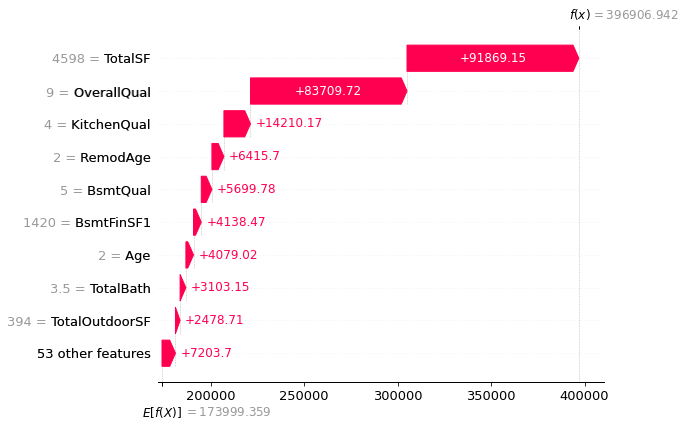

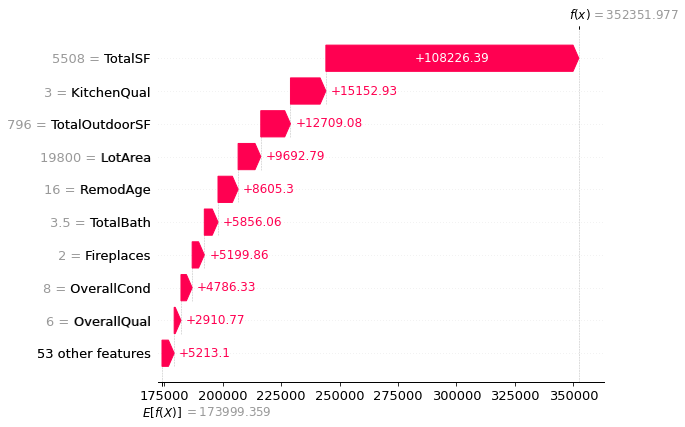

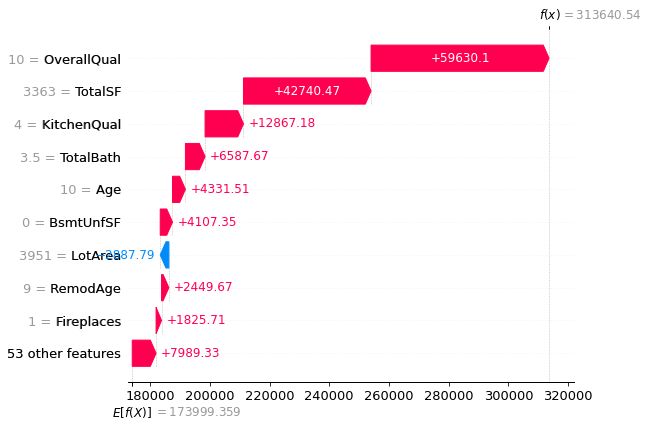

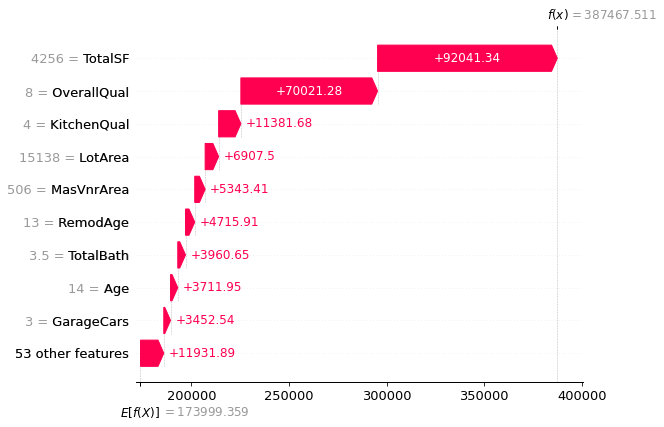

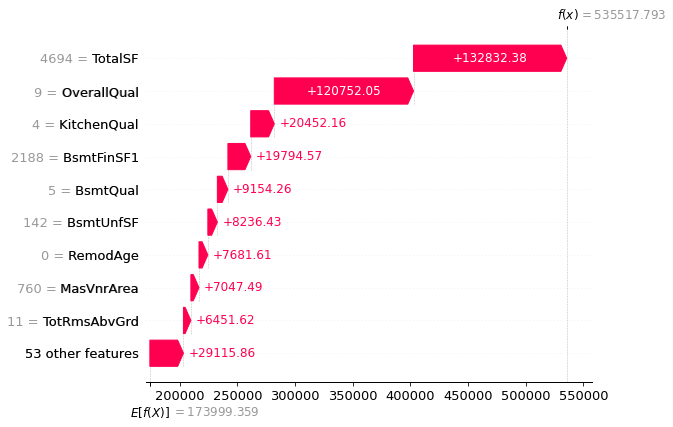

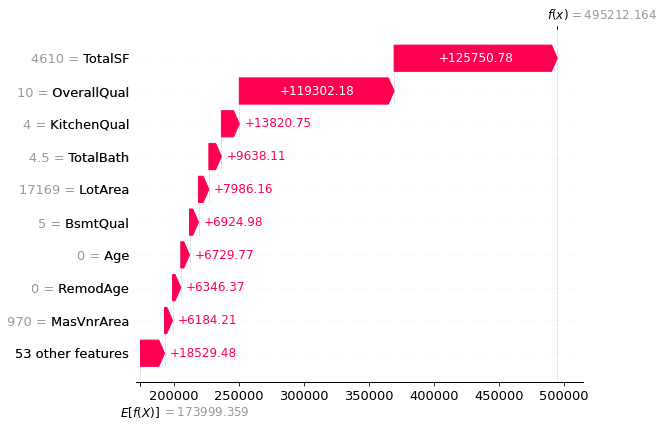

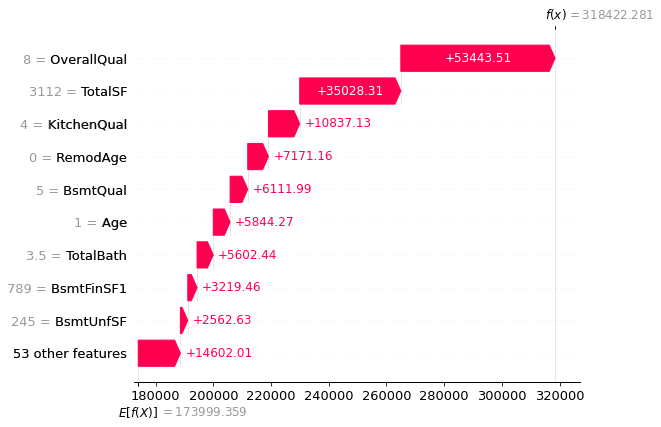

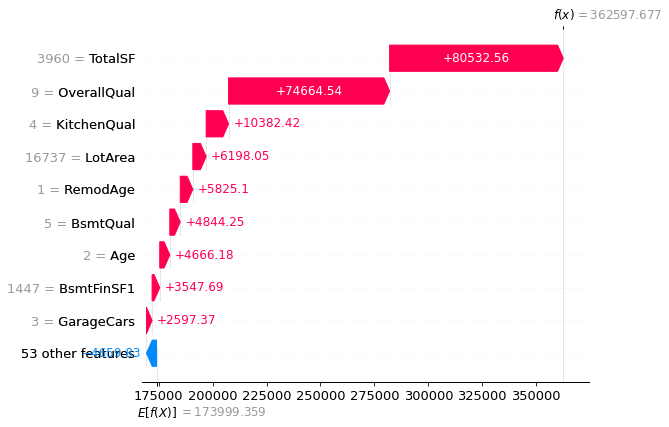

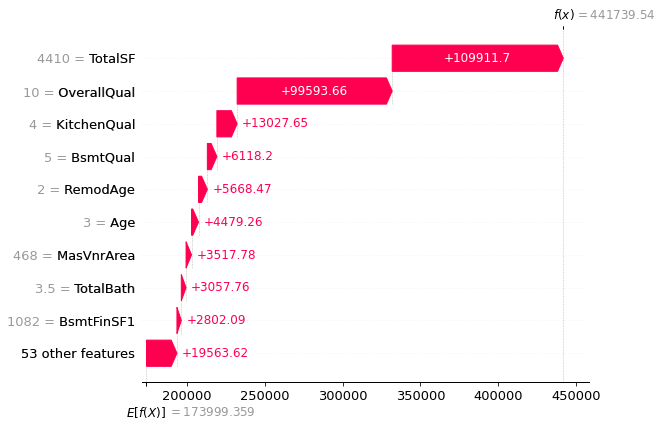

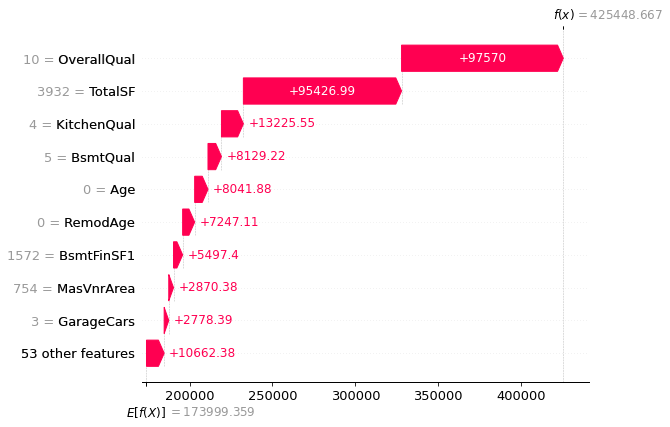

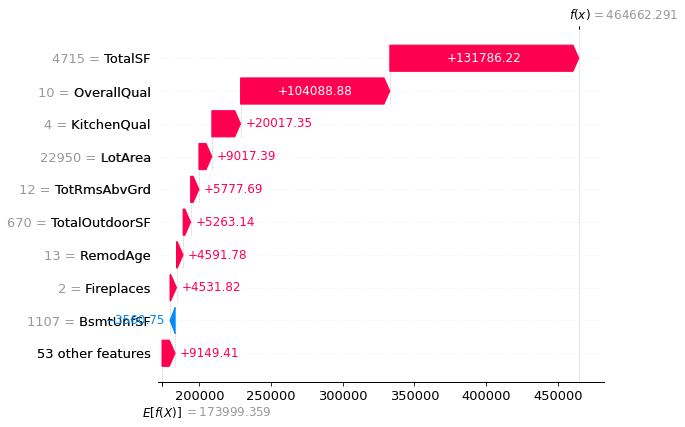

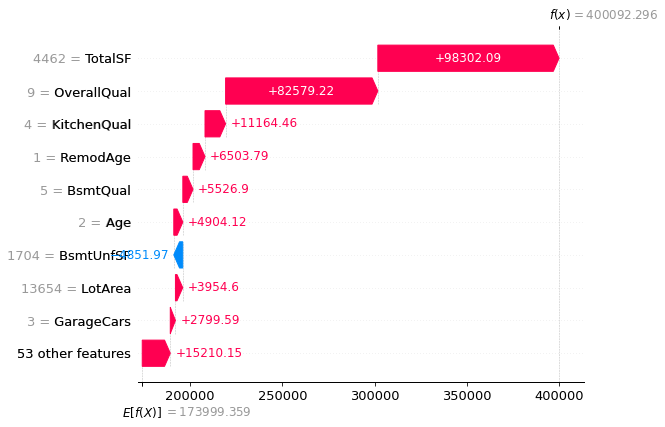

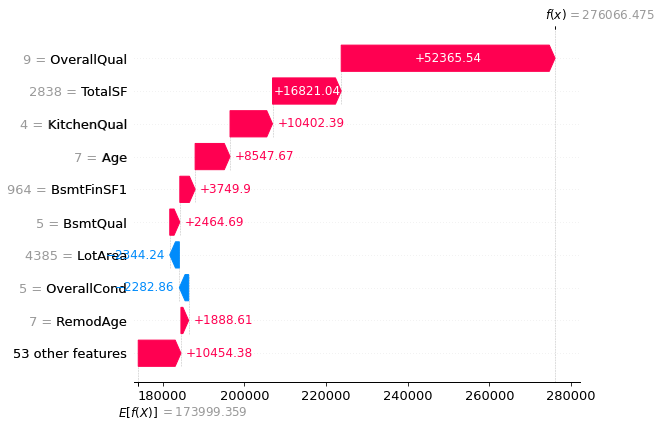

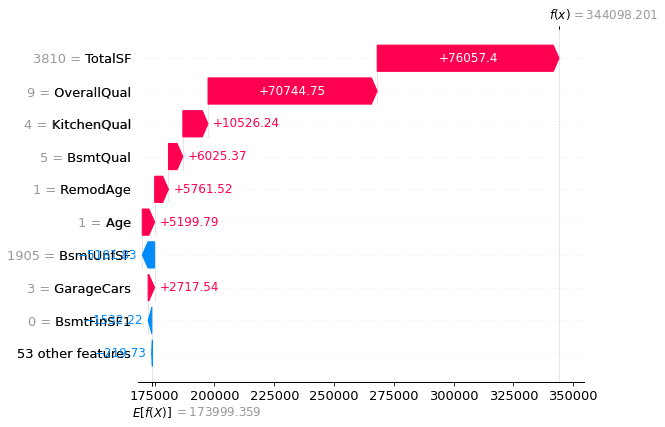

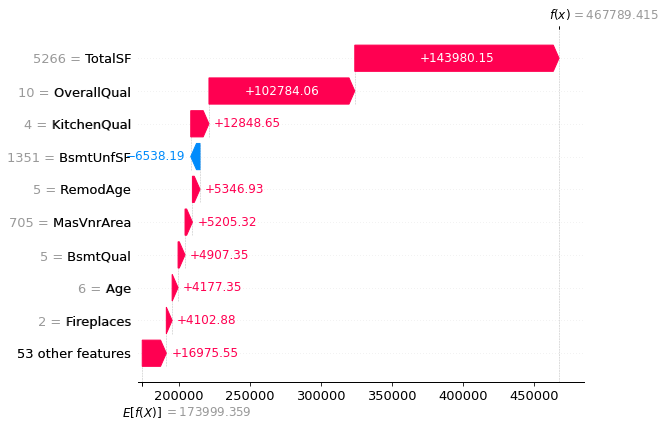

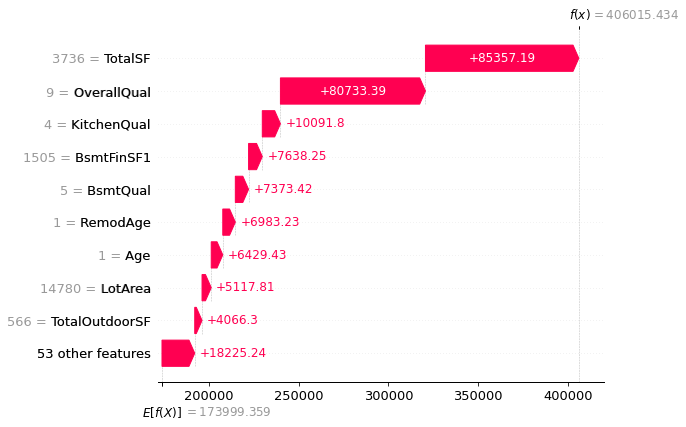

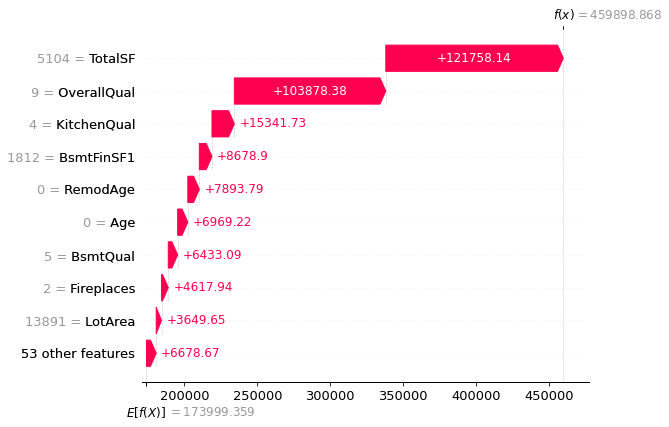

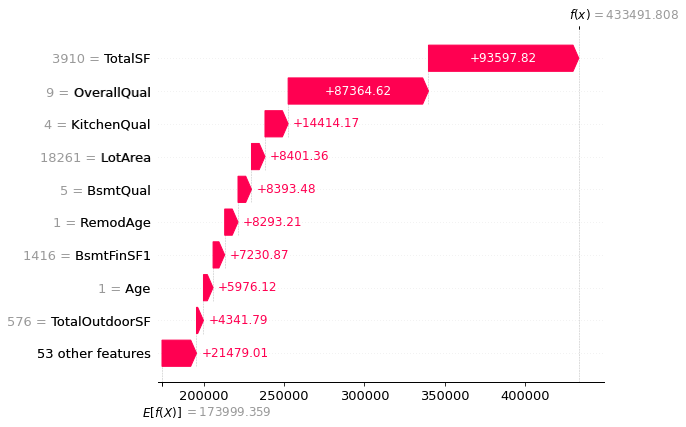

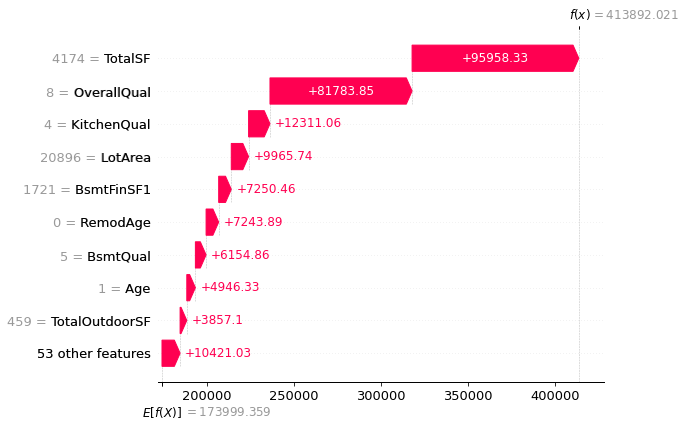

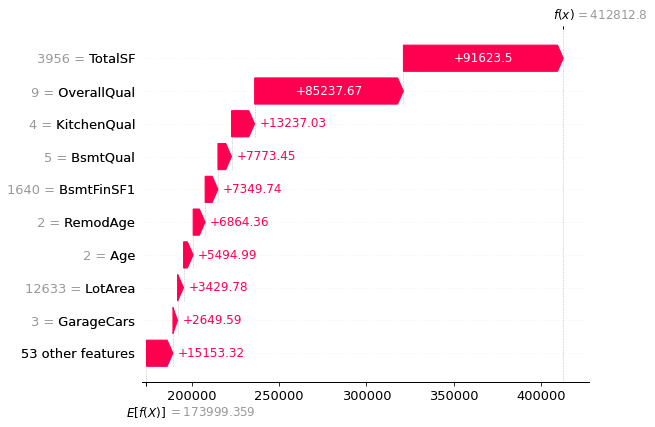

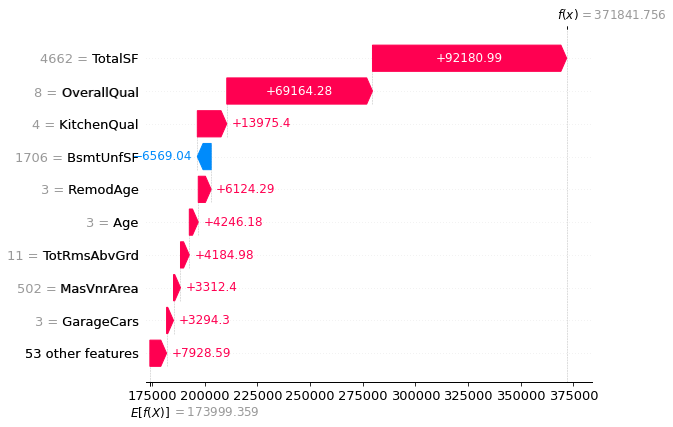

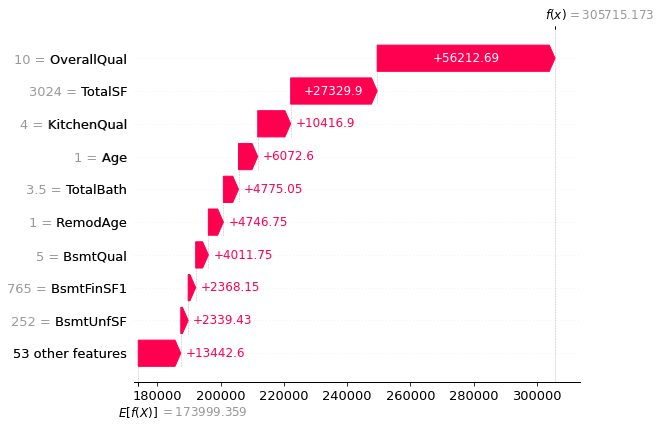

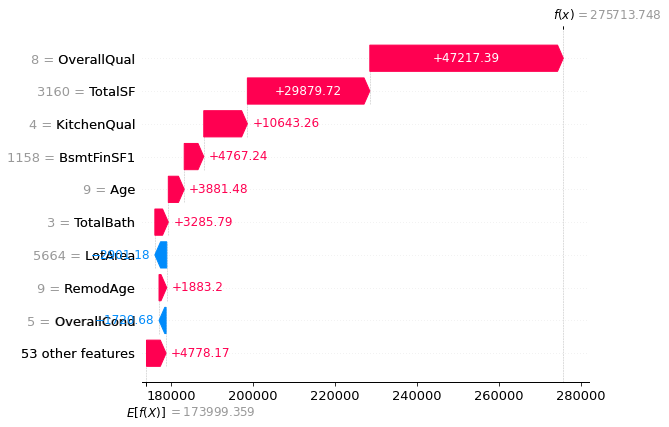

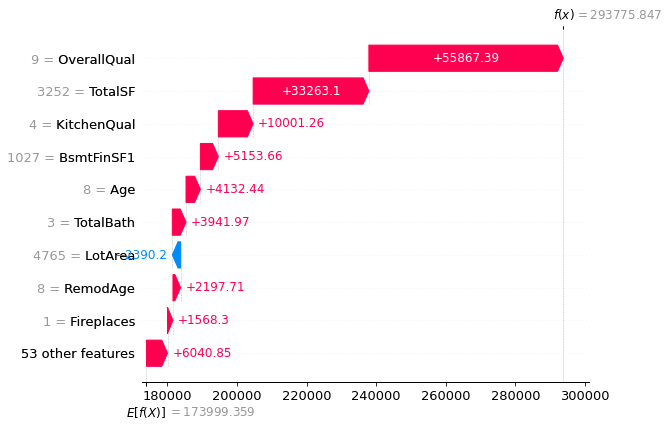

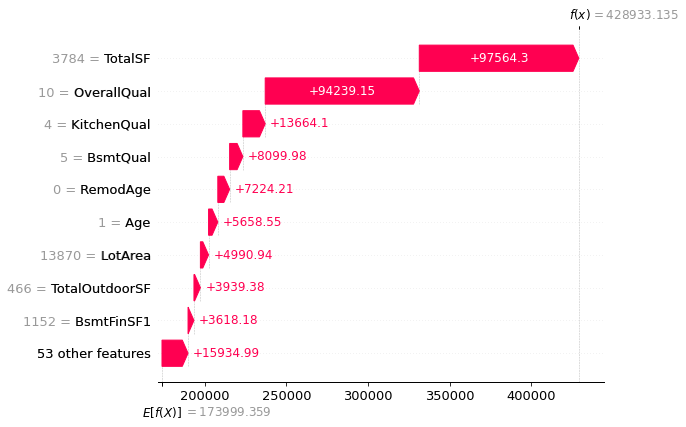

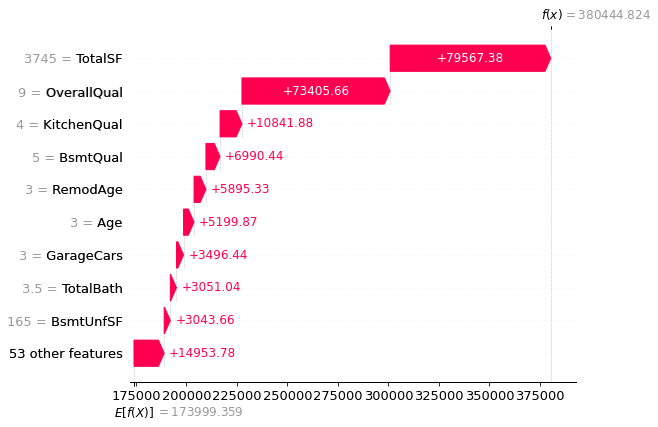

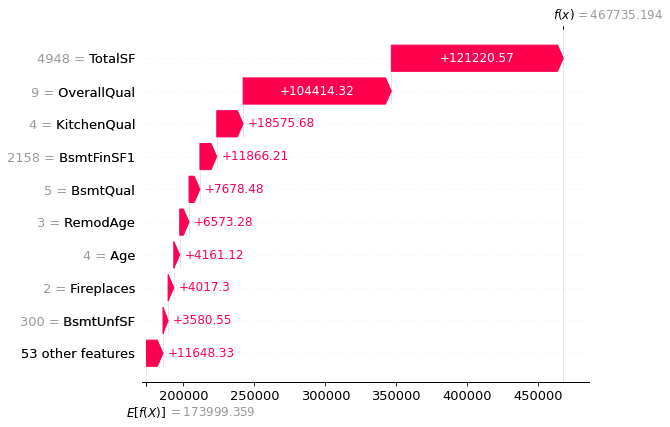

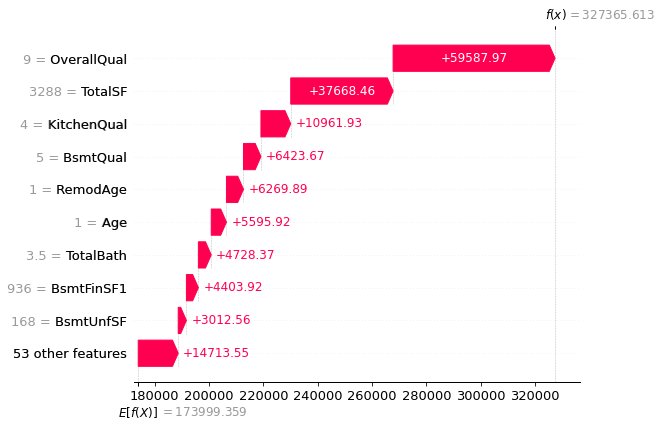

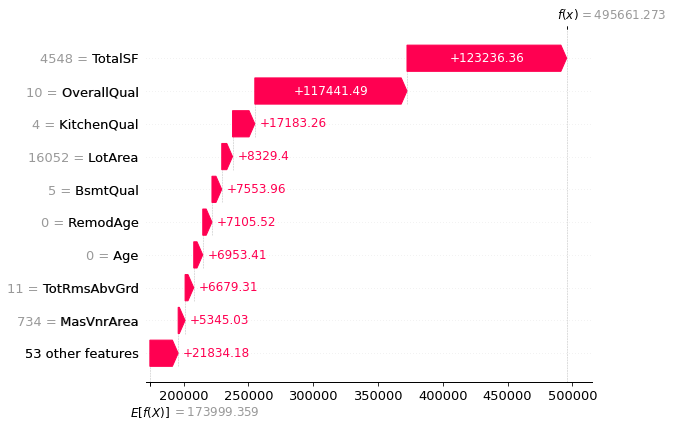

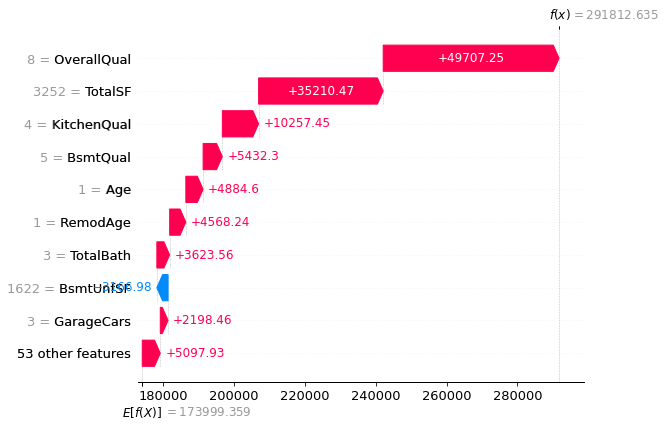

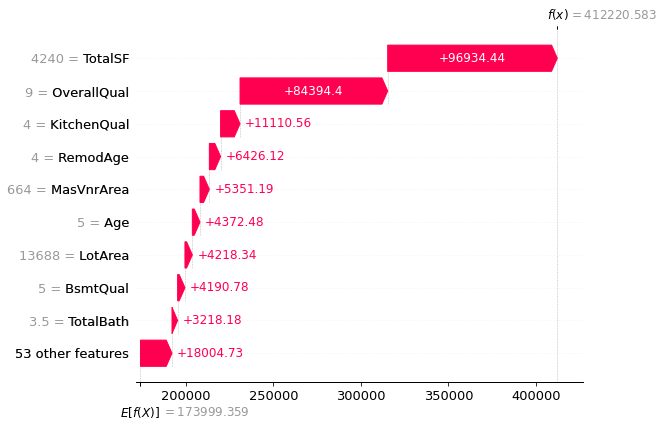

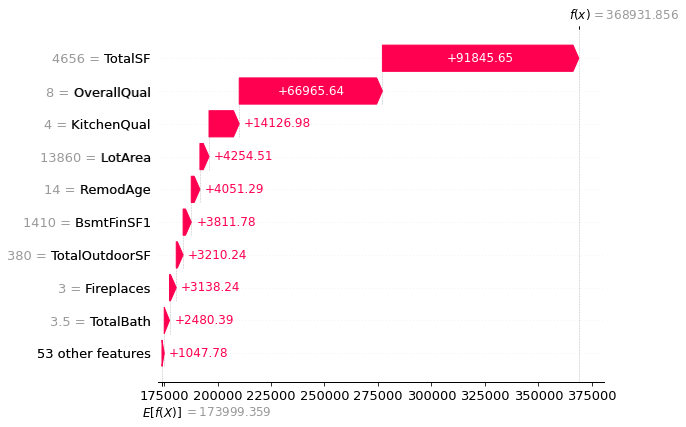

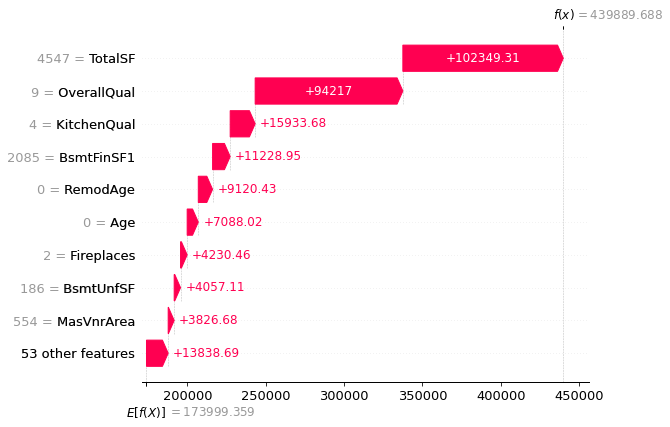

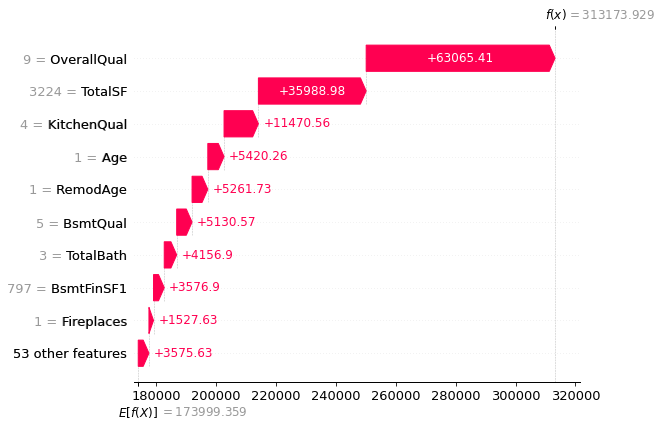

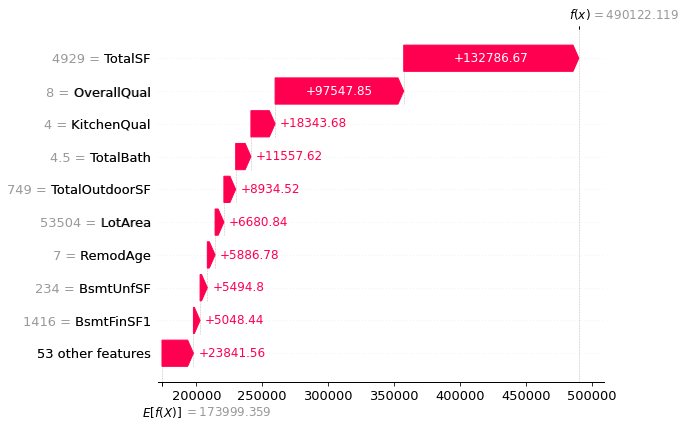

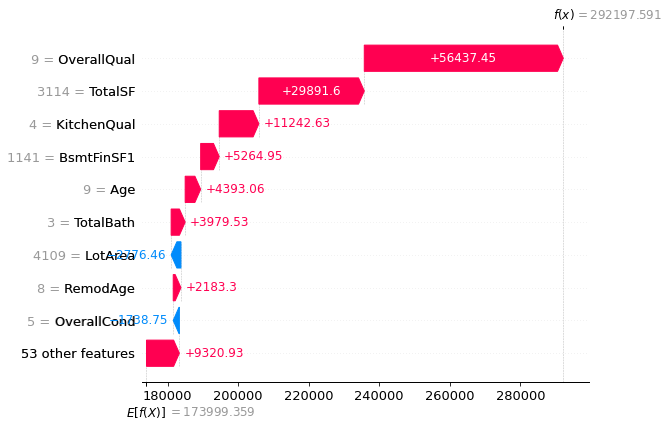

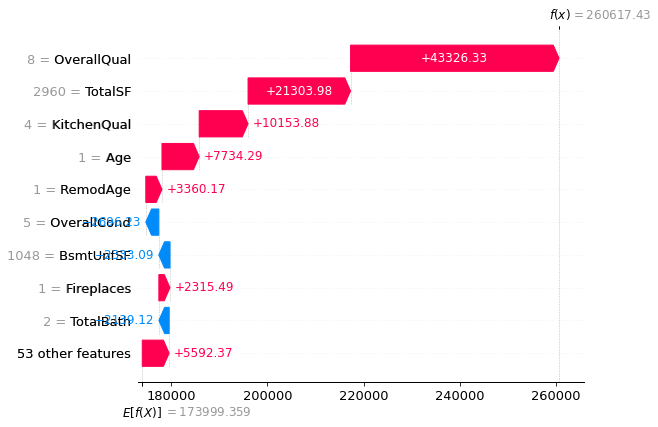

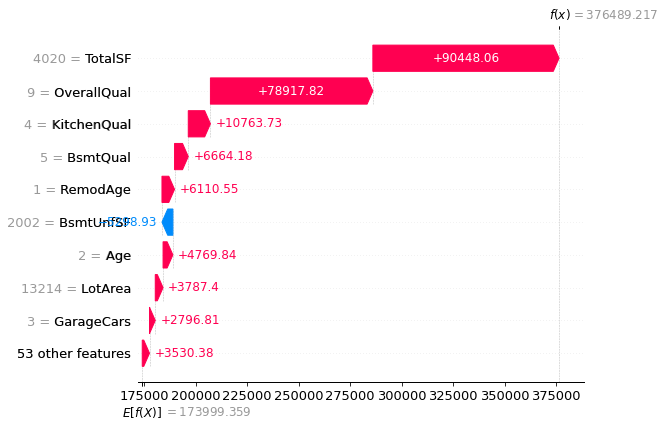

<IPython.core.display.Javascript object>

In [76]:
# Finding indices of observations with a SHAP value for TotalBath greater than 10000
high_shap_indices = np.where(
    shap_values[:, X_train.columns.get_loc("KitchenQual")].values > 10000
)[0]

print("Indices of observations with high SHAP values for TotalBath:", high_shap_indices)

# Plot the SHAP values as a waterfall plot for each high-value observation
for index in high_shap_indices:
    shap_values_instance = explainer(X_train.iloc[index : index + 1, :])
    shap.plots.waterfall(shap_values_instance[0])
    plt.show()

## Did home buyers value a half bathroom in the basement less than in a floor above ground? Was there more of a value on outdoor space in the summer months?

In [77]:
# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Convert the SHAP values to a DataFrame for easier analysis
shap_values_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

# Add the 'MoSold' column to the SHAP values DataFrame
shap_values_df['MoSold'] = X_train['MoSold'].values

# Calculate the average SHAP value for BsmtHalfBath and HalfBath
avg_shap_BsmtHalfBath = shap_values_df['BsmtHalfBath'].mean()
avg_shap_HalfBath = shap_values_df['HalfBath'].mean()

print("Average SHAP value for BsmtHalfBath:", avg_shap_BsmtHalfBath)
print("Average SHAP value for HalfBath:", avg_shap_HalfBath)

# Define a function to categorize months into summer and non-summer
def is_summer(month):
    return month in [6, 7, 8]

# Create a new column 'IsSummer' in the SHAP values DataFrame
shap_values_df['IsSummer'] = shap_values_df['MoSold'].apply(is_summer)

# Calculate the average SHAP value for TotalOutdoorSF in summer and non-summer months
avg_shap_TotalOutdoorSF_summer = shap_values_df.loc[shap_values_df['IsSummer'], 'TotalOutdoorSF'].mean()
avg_shap_TotalOutdoorSF_non_summer = shap_values_df.loc[~shap_values_df['IsSummer'], 'TotalOutdoorSF'].mean()

print("Average SHAP value for TotalOutdoorSF in summer months:", avg_shap_TotalOutdoorSF_summer)
print("Average SHAP value for TotalOutdoorSF in non-summer months:", avg_shap_TotalOutdoorSF_non_summer)


100%|===================| 2043/2046 [01:18<00:00]        

Average SHAP value for BsmtHalfBath: -1.0319415572690753
Average SHAP value for HalfBath: -19.354547314736198
Average SHAP value for TotalOutdoorSF in summer months: -13.953917941055199
Average SHAP value for TotalOutdoorSF in non-summer months: -140.74125170873515


<IPython.core.display.Javascript object>

The above negative numbers means something was done wrong.  Maybe TotalOutdoorSF and the half baths should be a binary of yes or no?

### Im going to look into a few other shap values.  Now that there I have the dataframe (shap_values_df) of shap values i can explore the values more

In [78]:
# Adding the original values as a column to the dataframe of shap values which will allow me to 
# look at the average shap values for differen values in the Totalbath column
shap_values_df['TotalBath_values'] = X_train['TotalBath'].values

for i in range(1, 7):
    avg_shap_TotalBath = shap_values_df.loc[shap_values_df['TotalBath_values'] == i, 'TotalBath'].mean()
    print(f"Average SHAP value for TotalBath {i}: {avg_shap_TotalBath}")

# Drop the 'TotalBath_values' column
shap_values_df.drop(columns=['TotalBath_values'], inplace=True)


Average SHAP value for TotalBath 1: -4553.000240201233
Average SHAP value for TotalBath 2: -2060.175802309384
Average SHAP value for TotalBath 3: 2681.264283865697
Average SHAP value for TotalBath 4: 4492.770270299122
Average SHAP value for TotalBath 5: 3584.9954000869393
Average SHAP value for TotalBath 6: 5698.093665700257


<IPython.core.display.Javascript object>

The numbers for the totalbath look more promising.  Im assuming there is a negative shap value for 1 and 2 bathrooms because the house is large(with a lot of bedrooms) and there needs to be a higher amount of bathrooms
to handle the extra loads!

In [79]:

# Im doing the same thing to look at the average shap values for a house remodeled and not remodeled
shap_values_df['Remodeled_values'] = X_train['Remodeled'].values

for i in [0, 1]:
    avg_shap_Remodeled = shap_values_df.loc[shap_values_df['Remodeled_values'] == i, 'Remodeled'].mean()
    print(f"Average SHAP value for Remodeled {i}: {avg_shap_Remodeled}")

# Drop the 'Remodeled_values' column
shap_values_df.drop(columns=['Remodeled_values'], inplace=True)


Average SHAP value for Remodeled 0: -51.60085588571549
Average SHAP value for Remodeled 1: 74.79499760360406


<IPython.core.display.Javascript object>

Not much of a difference here.  This might be because we are looking at the average of all of the observations instead of just looking at similiar properties. For example, is there much of a difference in sale price when 
most of the other features are similiar and the homes were built around the same time?

In [80]:
# I'm now doing the same thing with functional value
shap_values_df['Functional_values'] = X_train['Functional'].values
unique_functional_values = X_train['Functional'].unique()

for value in unique_functional_values:
    avg_shap_Functional = shap_values_df.loc[shap_values_df['Functional_values'] == value, 'Functional'].mean()
    print(f"Average SHAP value for Functional '{value}': {avg_shap_Functional}")

# Drop the 'Functional_values' column
shap_values_df.drop(columns=['Functional_values'], inplace=True)


Average SHAP value for Functional '6.0': 41.42045037035947
Average SHAP value for Functional '3.0': -597.0840695784918
Average SHAP value for Functional '2.0': -935.8012361424463
Average SHAP value for Functional '1.0': -1368.1197393600144
Average SHAP value for Functional '4.0': -506.2002358804135
Average SHAP value for Functional '0.0': -1923.0277374207124
Average SHAP value for Functional '5.0': -232.08902494847774


<IPython.core.display.Javascript object>

## The house value decreases a lot when the functionality is zero which should be a house that is Salvage only as defined below
Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

Odd that there is only 7 values in my dataset even though the dictionary that came with the dataset shows 8 different variables.  Ill look at the original dataset to explore further

In [81]:
# Loading original dataframe
df = pd.read_csv("../data/housing_cleaned.csv")
# Printing values for functional column
df["Functional"].value_counts()

Typ     2381
Min2      65
Min1      56
Mod       31
Maj1      18
Maj2       7
Sal        1
Name: Functional, dtype: int64

<IPython.core.display.Javascript object>

Looks like there is no Sev (severly damaged) in the dataset.  It also looks like there is only one Sal(Salvage only) so if the test train is split differently it wouldnt show up in this part of the data

## Looking at the average shap value for features (such as if a home was remodeled) doesnt make much sense unless we are looking at similiar properties.  This is where  Cosine similarity is useful....

To compare similiar homes I will:

1. Choose the features I want to consider for similarity (e.g., TotalSF, OverallQual, YearBuilt).
2. Normalize the selected features.
3. Calculate the cosine similarity between each pair of homes.
4. Find similar homes based on a similarity threshold or by selecting the top N most similar homes.
5. Compare the average SHAP values for remodeled and non-remodeled homes within the similar homes group.

In [82]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Reset the indices of X_train and shap_values_df
X_train.reset_index(drop=True, inplace=True)
shap_values_df.reset_index(drop=True, inplace=True)

# Select features to use for similarity
features = ['TotalSF', 'Age', 'Neighborhood', 'TotalBath']
X_similarity = X_train[features]

# Normalize the features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_similarity)

# Calculate cosine similarity between each pair of homes
cosine_sim = cosine_similarity(X_normalized)

# Set a similarity threshold or select the top N most similar homes
similarity_threshold = 0.95

# Add Remodeled column to X_train to filter by remodeled status later
X_train['Remodeled'] = X_train['Remodeled'].values

# Re-index the shap_values_df DataFrame to match X_train's index
# shap_values_df = shap_values_df.loc[X_train.index]

# Loop through each home and find similar homes
similar_homes = []
for index, similarities in enumerate(cosine_sim):
    # Get the indices of similar homes
    similar_indices = [i for i, sim in enumerate(similarities) if sim >= similarity_threshold and i != index]
    
    if similar_indices:
        # Get the original indices in X_train
        similar_original_indices = X_train.iloc[similar_indices].index
        # Add the current home index and its similar homes indices
        similar_homes.append((X_train.index[index], similar_original_indices))

# Calculate the average SHAP values for remodeled and non-remodeled homes within the similar homes group
remodeled_shap_values = []
non_remodeled_shap_values = []

for home, similar_indices in similar_homes:
    for idx in similar_indices:
        if X_train.loc[idx, 'Remodeled'] == 1:
            remodeled_shap_values.append(shap_values_df.loc[idx, 'Remodeled'])
        else:
            non_remodeled_shap_values.append(shap_values_df.loc[idx, 'Remodeled'])

avg_shap_remodeled = sum(remodeled_shap_values) / len(remodeled_shap_values)
avg_shap_non_remodeled = sum(non_remodeled_shap_values) / len(non_remodeled_shap_values)

print(f"Average SHAP value for similar remodeled homes: {avg_shap_remodeled}")
print(f"Average SHAP value for similar non-remodeled homes: {avg_shap_non_remodeled}")


Average SHAP value for similar remodeled homes: 76.06322546446509
Average SHAP value for similar non-remodeled homes: -47.70340401383594


<IPython.core.display.Javascript object>

### It looks like this has very little effect however that is most likely because our model does not give high SHAP values for the binary remodeled feature.  This could be because our model also factors the condition and quality of items that can be remodeled

## Going back to the number of bathrooms I will now look at how the SHAP values of Total_bath changes when looking at the size of a home

In [83]:
# First i want to look at how many larger homes are in the dataset
X_train[X_train["TotalSF"] > 3000].count()

MSZoning          468
LotFrontage       468
LotArea           468
Street            468
Alley             468
LotShape          468
LandContour       468
Utilities         468
LotConfig         468
LandSlope         468
Neighborhood      468
Condition1        468
Condition2        468
BldgType          468
HouseStyle        468
OverallQual       468
OverallCond       468
RoofStyle         468
RoofMatl          468
Exterior1st       468
Exterior2nd       468
MasVnrType        468
MasVnrArea        468
ExterCond         468
Foundation        468
BsmtQual          468
BsmtCond          468
BsmtExposure      468
BsmtFinSF1        468
BsmtFinSF2        468
BsmtUnfSF         468
Heating           468
HeatingQC         468
CentralAir        468
Electrical        468
BsmtFullBath      468
BsmtHalfBath      468
HalfBath          468
BedroomAbvGr      468
KitchenAbvGr      468
KitchenQual       468
TotRmsAbvGrd      468
Functional        468
Fireplaces        468
GarageType        468
GarageFini

<IPython.core.display.Javascript object>

In [84]:
# Add the 'TotalSf_values' column to the shap_values_df DataFrame
shap_values_df['TotalSF_values'] = X_train['TotalSF'].values

# Filter the shap_values_df DataFrame based on the 'TotalSf_values' column
shap_values_df_filtered = shap_values_df[shap_values_df['TotalSF_values'] > 3000].copy()

# Add the 'TotalBath_values' column to the filtered shap_values_df DataFrame
shap_values_df_filtered['TotalBath_values'] = X_train.loc[shap_values_df_filtered.index, 'TotalBath'].values

# Calculate the average SHAP value for each TotalBath
for i in range(1, 7):
    avg_shap_TotalBath = shap_values_df_filtered.loc[shap_values_df_filtered['TotalBath_values'] == i, 'TotalBath'].mean()
    print(f"Average SHAP value for TotalBath {i}: {avg_shap_TotalBath}")

# Drop the 'TotalSf_values' and 'TotalBath_values' columns
shap_values_df_filtered.drop(columns=['TotalSF_values', 'TotalBath_values'], inplace=True)


Average SHAP value for TotalBath 1: -4477.860948557258
Average SHAP value for TotalBath 2: -2148.8068749847293
Average SHAP value for TotalBath 3: 2723.9661076496614
Average SHAP value for TotalBath 4: 4736.113618889544
Average SHAP value for TotalBath 5: 3584.9954000869393
Average SHAP value for TotalBath 6: nan


<IPython.core.display.Javascript object>

Great!  This shows there is an average SHAP penalty of $4,477 in homes over 3000 SF with only one bathroom 

## It looks like the penalty for having only one bathroom in a smaller home is less which makes sense

In [85]:
# Add the 'TotalSf_values' column to the shap_values_df DataFrame
shap_values_df["TotalSF_values"] = X_train["TotalSF"].values

# Filter the shap_values_df DataFrame based on the 'TotalSf_values' column
shap_values_df_filtered = shap_values_df[shap_values_df["TotalSF_values"] < 1400].copy()

# Add the 'TotalBath_values' column to the filtered shap_values_df DataFrame
shap_values_df_filtered["TotalBath_values"] = X_train.loc[
    shap_values_df_filtered.index, "TotalBath"
].values

# Calculate the average SHAP value for each TotalBath
for i in range(1, 7):
    avg_shap_TotalBath = shap_values_df_filtered.loc[
        shap_values_df_filtered["TotalBath_values"] == i, "TotalBath"
    ].mean()
    print(f"Average SHAP value for TotalBath {i}: {avg_shap_TotalBath}")

# Drop the 'TotalSf_values' and 'TotalBath_values' columns
shap_values_df_filtered.drop(
    columns=["TotalSF_values", "TotalBath_values"], inplace=True
)

shap_values_df.drop(columns=["TotalSF_values"], inplace=True)

Average SHAP value for TotalBath 1: -3665.894355136552
Average SHAP value for TotalBath 2: -1670.9231063400175
Average SHAP value for TotalBath 3: nan
Average SHAP value for TotalBath 4: nan
Average SHAP value for TotalBath 5: nan
Average SHAP value for TotalBath 6: nan


<IPython.core.display.Javascript object>

In [86]:
shap_values_df

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,Age,RemodAge,TotalSF,Remodeled,TotalBath,MSSubClass_cat,Street_type,TotalOutdoorSF,IsSummer
0,385.626834,474.477792,-1125.573198,0.0,-35.570503,-226.276112,-75.375439,0.0,-11.100961,-32.470542,-376.142261,48.143501,0.0,58.812220,-857.634579,-10973.943684,-920.290517,-29.189787,0.0,-21.972964,-91.934762,-10.524900,-419.678838,-2.142048,-127.329496,-173.767848,5.395601,-85.949252,415.001537,46.630821,523.329024,1.015922,-731.786428,168.665832,24.868148,-129.434824,-7.596488,-238.207465,-38.260218,25.692554,-1739.884852,-62.311410,9.292476,-2035.214765,-710.426906,-387.229659,-2885.416902,135.698765,40.808262,-42.352689,10,-26.692635,-223.317612,-664.893412,-5163.590350,-4482.607524,-15864.310056,20.130153,-5043.340606,-739.789279,-240.286302,557.202586,False
1,-3788.497044,-759.877074,-3420.969058,0.0,-8.561875,-140.131777,-122.433574,0.0,4.694622,-27.324687,1163.708314,32.894764,0.0,96.535091,-686.903666,4871.365066,-2267.563753,-4.618161,0.0,-321.963646,0.677031,-4.749209,-400.831584,-16.202711,-318.094263,-316.325875,23.799500,55.206045,-447.389991,182.966392,902.197808,0.935578,-756.738164,104.933769,12.433744,-518.535774,-7.911126,-162.493777,-240.675715,35.228357,-2940.641366,-234.915654,-635.907875,2409.011205,-792.789090,-514.012180,869.781842,-9.309583,68.229844,5.989911,1,-81.368207,-15.207368,18.935131,-3573.164197,-6013.392295,15481.223770,26.211281,-2143.587603,-4.769009,-416.829952,-1270.389865,False
2,1300.057964,-71.718628,-672.499202,0.0,-7.593083,-18.986754,-27.870673,0.0,7.450747,-30.202307,1089.937310,26.803553,0.0,101.379275,325.912281,3841.538666,-743.576186,-5.383525,0.0,231.295083,547.874734,30.104977,484.537594,3.838674,215.584359,68.799737,7.092241,-82.088198,-871.557923,28.807017,-2347.880693,0.458739,408.120722,97.389369,43.743830,-195.173463,-10.719341,241.152949,-146.031416,19.155055,2655.222777,-19.025202,139.476293,-1230.665150,737.617110,533.739120,1468.457826,51.005677,38.413242,-20.743665,8,-67.206772,-30.134351,15.018083,5949.713695,3880.384237,1951.239138,-8.883235,2380.121373,594.126550,145.440762,2472.881544,True
3,219.049227,486.218673,-175.219359,0.0,-7.388034,-80.989986,-48.236780,0.0,68.203292,-29.620986,-417.243946,30.013120,0.0,78.930342,-276.597672,2395.591559,-360.476616,-5.195809,0.0,47.087767,40.158449,8.190757,-328.789435,7.698487,134.534199,73.571948,6.389873,160.899316,-994.730941,33.234437,-571.578478,0.217278,355.230599,127.781454,5.680363,-159.549919,-6.922818,-117.408530,-35.401550,15.617212,1456.913789,-120.400763,23.947981,-1328.833263,677.100454,801.705925,1258.979479,34.023964,39.617496,-25.906722,3,-52.144212,-4.654319,8.911951,8754.961102,2560.553766,-15312.459750,-29.656279,-2623.101958,-743.861217,-13.453372,-1241.419959,False
4,456.055174,518.384385,1417.497743,0.0,-6.035336,-170.119010,-61.203493,0.0,51.863912,-30.140914,-902.050647,16.263075,0.0,78.034772,547.611797,-6221.520025,1318.132951,45.687939,0.0,-273.046367,-590.678585,-11.363506,-291.295496,-1.375346,-243.404987,-204.519633,26.685427,278.937354,394.836470,27.770239,-911.142399,0.467103,358.011881,129.034767,22.081271,52.758591,-8.565115,-214.746721,76.964327,34.022029,2616.861002,2.581636,45.374868,2094.653747,487.633289,593.770158,1746.677771,24.985204,57.750699,32.197742,9,-201.840994,2.597947,19.814785,-2565.642867,-4930.052448,5581.587119,-28.529279,-1262.998517,691.980023,-239.421260,-1029.079214,False
...,...,...,...,...,...,...,...,...,.

<IPython.core.display.Javascript object>

# Im now going to look into the 10 observations that have the highest SHAP value in the KitchenQual column.  I will then look at the other features of these 10 observations to find out what is similiar.  

In [87]:
# First im looking at the value counts of the original dataframe
df["KitchenQual"].value_counts()

TA    1343
Gd    1012
Ex     141
Fa      62
Po       1
Name: KitchenQual, dtype: int64

<IPython.core.display.Javascript object>

In [88]:
# Looking at the 10 observations where KitchenQual has the largest shap value.  Value range here is
# 15,341 - 20,452
shap_values_df.nlargest(10, "KitchenQual")


,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,Age,RemodAge,TotalSF,Remodeled,TotalBath,MSSubClass_cat,Street_type,TotalOutdoorSF,IsSummer
576,99.582699,1287.480317,2743.222871,0.0,0.727935,505.242714,165.065269,0.0,101.407864,-46.685837,1553.558269,42.531166,0.000000,86.221026,-223.745559,120752.049701,-907.636233,49.333860,0.000000,-36.629502,-18.323466,1278.026245,7047.492213,13.659541,540.302061,9154.263646,1.883858,1150.167237,19794.568562,41.121587,8236.427277,0.526554,774.834092,69.676256,4.786469,463.820259,-89.894529,539.973756,750.290901,16.797878,20452.160475,6451.623442,22.132747,3768.102238,523.234790,-3.694469,2704.394891,30.809832,25.140736,31.314787,3,1363.387031,537.253558,523.009562,4821.375278,7681.611596,132832.378943,214.468246,3149.445152,-210.883671,102.541401,-504.703444,False
855,-1356.421713,700.311606,9017.394138,0.0,-3.301403,489.118375,267.945911,0.0,18.873650,-48.209167,1681.218492,-233.029645,0.000000,54.139945,-151.354940,104088.877225,3553.299774,5.263272,1914.289398,-114.477044,-856.297458,-7.108325,-620.742480,-55.503144,-231.610528,-320.283974,1.486835,354.140338,-1013.482024,52.360823,-3560.754470,0.979224,893.866953,78.735511,6.571029,-281.741483,-137.312452,412.791864,-21.731960,15.209938,20017.351468,5777.687638,21.108990,4531.815269,-427.411553,-99.511352,2434.378374,1206.136178,29.640379,316.170091,6,95.076674,-24.527907,21.162607,-2241.288071,4591.784390,131786.220459,317.875641,819.968731,413.517242,133.526441,5263.141708,True
168,101.881055,3513.307480,7082.170943,0.0,-1.134788,250.407009,223.192846,0.0,-85.818883,-39.296258,754.638168,31.596617,0.000000,80.554165,278.815043,113952.509324,-1076.640364,-466.435891,0.000000,459.411029,964.301797,2.775736,6928.274033,-133.352599,604.651910,5755.557543,3.148927,908.147693,-463.416293,-221.966519,8633.427688,0.546046,654.349380,70.281953,4.239331,-0.954877,-98.876180,942.667203,-270.939977,15.213217,19149.925463,4106.292435,22.626908,1462.804085,463.627194,281.692627,2146.805909,26.986539,24.395945,12.573228,5,205.547785,-26.214767,27.741907,3564.532976,5243.345795,158949.651641,388.250171,12147.203317,475.677698,-334.301352,6778.655343,False
1347,94.843130,436.358106,1052.052267,0.0,-0.603835,-148.266584,153.159429,0.0,178.154181,-62.570616,1563.802115,-56.498100,-757.770356,81.800901,-138.376133,104414.320309,-1128.758470,-70.777253,0.000000,-453.881196,-140.042809,1060.243657,1139.172976,17.210225,556.858483,7678.478447,2.023024,928.940766,11866.211760,43.818280,3580.548068,0.502828,665.661619,67.262177,4.162302,371.460139,-147.550180,-410.342582,512.186612,18.944209,18575.684997,545.372537,31.816305,4017.296766,377.000337,-9.744268,2666.380502,30.827320,23.215484,350.599790,10,-81.942185,-22.795614,18.385165,4161.118555,6573.276911,121220.565156,146.834767,1798.165443,-302.411611,449.774280,1528.430317,False
190,99.757142,5673.894335,2133.910123,0.0,-0.711137,-130.277074,599.686997,0.0,-23.946562,1174.940584,1610.419730,44.140332,0.000000,80.137233,-123.644653,136242.798826,-1076.885260,-139.379931,0.000000,518.039197,756.813311,1211.089919,6320.788983,6.974651,634.354539,5555.301327,2.427790,1072.272431,13521.126174,49.465927,5740.163645,0.526554,660.968495,66.889121,3.574168,2375.965474,-152.031089,730.232606,1176.762891,17.606352,18356.665735,40.251122,31.704197,3382.023840,479.695386,150.886297,2351.182366,29.862309,24.210922,25.459501,2,-6.715575,-17.452657,27.565205,4011.143050,4615.229552,159582.240811,-154.832887

<IPython.core.display.Javascript object>

Looking at the top 10 descriptive stats vs the rest of the dataset

In [110]:
# Get the indices of the top 10 observations with the highest SHAP values for "KitchenQual"
top_10_indices = shap_values_df.nlargest(10, "KitchenQual").index

# Get the corresponding 10 observations in the X_train DataFrame
top_10_observations = X_train.loc[top_10_indices]

# Get the descriptive statistics for the top 30 observations
top_10_stats = top_10_observations.describe()

# Get the descriptive statistics for the rest of the X_train DataFrame
rest_of_X_train_stats = X_train.drop(top_10_indices).describe()

# Compare the descriptive statistics of both sets of observations
comparison = pd.concat([top_10_stats, rest_of_X_train_stats], axis=1, keys=['Top 10', 'Rest of X_train'])

comparison


Top 10                                                    \
        MSZoning LotFrontage       LotArea Street Alley   LotShape   
count  10.000000   10.000000     10.000000   10.0  10.0  10.000000   
mean    4.100000   92.700000  18587.700000    1.0   1.0   1.700000   
std     0.316228   19.183616  12741.091136    0.0   0.0   1.418136   
min     4.000000   47.000000  11128.000000    1.0   1.0   0.000000   
25%     4.000000   86.250000  12769.750000    1.0   1.0   0.250000   
50%     4.000000   95.500000  13792.000000    1.0   1.0   2.000000   
75%     4.000000  105.750000  16944.500000    1.0   1.0   3.000000   
max     5.000000  114.000000  53504.000000    1.0   1.0   3.000000   

                                                                           \
      LandContour Utilities  LotConfig  LandSlope Neighborhood Condition1   
count   10.000000      10.0  10.000000  10.000000    10.000000  10.000000   
mean     2.600000       0.0   3.000000   0.200000    17.500000   2.100000   
std      0.843274       0.0   1.632993   0.421637     5.169354   0.994429   
min      1.000000       0.0   0.000000   0.000000     5.000000   0.000000   
25%      3.000000       0.0   1.750000   0.000000    17.000000   2.000000   
50%      3.000000       0.0   4.000000   0.000000    17.000000   2.000000   
75%      3.000000       0.0   4.000000   0.000000    21.000000   2.000000   
max      3.000000       0.0   4.000000   1.000000    23.000000   4.000000   

                                                                         \
      Condition2 BldgType HouseStyle OverallQual OverallCond  RoofStyle   
count  10.000000     10.0  10.000000   10.000000   10.000000  10.000000   
mean    2.300000      0.0   3.000000    9.300000    5.400000   2.800000   
std     0.674949      0.0   1.414214    0.674949    1.264911   0.632456   
min     2.000000      0.0   2.000000    8.000000    5.000000   1.000000   
25%     2.000000      0.0   2.000000    9.000000    5.000000   3.000000   
50%     2.000000      0.0   2.000000    9.000000    5.000000   3.000000   
75%     2.000000      0.0   4.500000   10.000000    5.000000   3.000000   
max     4.000000      0.0   5.000000   10.000000    9.000000   3.000000   

                                                                           \
        RoofMatl Exterior1st Exterior2nd MasVnrType MasVnrArea  ExterCond   
count  10.000000   10.000000   10.000000  10.000000   10.00000  10.000000   
mean    0.600000   10.600000   12.300000   2.500000  519.50000   2.200000   
std     1.897367    2.633122    2.359378   0.849837  250.56525   0.421637   
min     0.000000    5.000000    8.000000   1.000000    0.00000   2.000000   
25%     0.000000    9.000000   13.000000   2.250000  460.00000   2.000000   
50%     0.000000   12.000000   13.000000   3.000000  578.50000   2.000000   
75%     0.000000   12.000000   13.000000   3.000000  720.50000   2.000000   
max     6.000000   13.000000   15.000000   3.000000  760.00000   3.000000   

                                                                             \
      Foundation   BsmtQual BsmtCond BsmtExposure   BsmtFinSF1   BsmtFinSF2   
count  10.000000  10.000000     10.0    10.000000    10.000000    10.000000   
mean    1.800000   4.600000      3.0     2.700000  1570.200000   139.300000   
std     0.632456   0.699206      0.0     0.674949   836.218047   440.505278   
min     0.000000   3.000000      3.0     1.000000     0.000000     0.000000   
25%     2.000000   4.250000      3.0     3.000000  1258.500000     0.000000   
50%     2.000000   5.000000      3.0     3.000000  1948.500000     0.000000   
75%     2.000000   5.000000      3.0     3.000000  2180.500000     0.000000   
max     2.000000   5.000000      3.0     3.000000  2288.000000  1393.000000   

                                                                         \
         BsmtUnfSF Heating HeatingQC CentralAir Electrical BsmtFullBath   
count    10.000000    10.0      10.0       10.0       10.0    10.000000   


<IPython.core.display.Javascript object>

In [ ]:
top_10_stats

The 10 observations that are mostly similar are street type, alley, utilities, building type, heating, heating quality, central air, electrical system, and the number of kitchens above grade. 

The features that are not similiar are lot frontage, lot area, basement finish square footage, mas masonry veneer area, and total outdoor square footage, among other features.

## Are the similiar features significant when compared to the rest of the dataset?

In [111]:

from scipy.stats import ttest_ind

# Assuming you have the top 30 observations and the entire X_train data as DataFrames
top_10_df = top_10_observations
x_train_df = X_train.drop(top_10_indices)

# List to store the names of significantly different features
significant_features = []

# Perform a two-sample t-test for each feature
for column in top_10_df.columns:
    t_stat, p_value = ttest_ind(top_10_df[column], x_train_df[column])
    
    # Check for significance (usually a significance level of 0.05 is used)
    if p_value < 0.0000005:
        significant_features.append(column)

# Print the significantly different features
print("Significantly different features:")
for feature in significant_features:
    print(feature)


Significantly different features:
LotArea
OverallQual
RoofStyle
MasVnrArea
BsmtFinSF1
KitchenQual
TotRmsAbvGrd
Fireplaces
GarageCars
TotalSF
TotalBath
TotalOutdoorSF


<IPython.core.display.Javascript object>

# Looking at the values of the significant in the Top 10 and again at the rest of the dataset

In [112]:
# List of features I'm interested in
features = [
    "LotArea", "OverallQual", "RoofStyle", "MasVnrArea", "BsmtFinSF1",
    "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
    "TotalSF", "TotalBath", "TotalOutdoorSF"
]

# Getting the summary statistics for the selected features
summary_stats = top_10_observations[features].describe()

# Filter only the min, max, and mean rows from the summary statistics
summary_stats.loc[["min", "max", "mean"]]



,LotArea,OverallQual,RoofStyle,MasVnrArea,BsmtFinSF1,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,TotalSF,TotalBath,TotalOutdoorSF
min,11128.0,8.0,1.0,0.0,0.0,4.0,7.0,1.0,3.0,4547.0,2.50,67.0
max,53504.0,10.0,3.0,760.0,2288.0,4.0,12.0,2.0,3.0,5304.0,4.50,1166.0
mean,18587.7,9.3,2.8,519.5,1570.2,4.0,9.6,1.7,3.0,4902.7,3.55,452.6


<IPython.core.display.Javascript object>

In [113]:
# List of features you're interested in
features = [
    "LotArea", "OverallQual", "RoofStyle", "MasVnrArea", "BsmtFinSF1",
    "KitchenQual", "TotRmsAbvGrd", "Fireplaces", "GarageCars",
    "TotalSF", "TotalBath", "TotalOutdoorSF"
]

all_the_rest = X_train.drop(top_10_indices)

# Get the summary statistics for the selected features
summary_stats = all_the_rest[features].describe()

# Filter only the min, max, and mean rows from the summary statistics
summary_stats.loc[["min", "max", "mean"]]



,LotArea,OverallQual,RoofStyle,MasVnrArea,BsmtFinSF1,KitchenQual,TotRmsAbvGrd,Fireplaces,GarageCars,TotalSF,TotalBath,TotalOutdoorSF
min,1300.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,334.000000,1.000000,0.000000
max,57200.000000,10.000000,5.000000,1600.000000,2260.000000,4.000000,13.000000,4.000000,5.000000,7814.000000,7.000000,1424.000000
mean,9820.904224,6.017191,1.374754,96.081532,439.689587,2.475933,6.368861,0.598723,1.739194,2509.658153,2.202358,185.169941


<IPython.core.display.Javascript object>

# So it looks like larger houses that are worth more money have a larger SHAP value for KitchenQual. Something that should of been obvious but i will leave the code here in case i want to look at something that is less obvious using a similiar process

In [114]:
X_train

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageQual,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,Age,RemodAge,TotalSF,Remodeled,TotalBath,MSSubClass_cat,Street_type,TotalOutdoorSF
0,4.0,80.0,8480,1.0,1.0,3.0,3.0,0.0,4.0,0.0,13.0,2.0,2.0,0.0,0.0,5,5,1.0,0.0,8.0,8.0,2.0,0.0,2,1.0,3,3,1,442.0,0.0,390.0,1.0,2,1.0,3.0,0.0,0.0,0,2,1,2,6,6.0,0,5.0,1,1.0,3,2.0,0,10,2008,0.0,0.0,61,58,2048.0,1,1.0,9.0,10.0,260
1,5.0,52.0,6240,1.0,1.0,3.0,3.0,0.0,4.0,0.0,3.0,2.0,2.0,0.0,0.0,7,5,1.0,0.0,13.0,14.0,2.0,0.0,2,0.0,3,3,2,300.0,240.0,449.0,1.0,2,1.0,3.0,0.0,0.0,0,4,1,2,7,3.0,1,5.0,1,2.0,3,2.0,3,1,2008,9.0,4.0,69,58,2998.0,1,2.0,9.0,0.0,20
2,4.0,65.0,8158,1.0,1.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7,5,1.0,0.0,12.0,13.0,1.0,214.0,2,2.0,4,3,1,0.0,0.0,860.0,1.0,4,1.0,3.0,0.0,0.0,1,3,1,3,7,6.0,0,1.0,3,2.0,3,2.0,0,8,2007,9.0,4.0,5,5,2589.0,0,2.5,10.0,10.0,449
3,4.0,81.0,9260,1.0,1.0,3.0,3.0,0.0,0.0,0.0,21.0,2.0,2.0,0.0,2.0,7,5,1.0,0.0,12.0,13.0,2.0,0.0,2,2.0,4,3,2,0.0,0.0,1162.0,1.0,4,1.0,3.0,0.0,0.0,0,3,1,3,6,6.0,0,1.0,3,2.0,3,2.0,0,3,2008,9.0,4.0,1,1,2324.0,0,2.0,5.0,0.0,32
4,4.0,85.0,11475,1.0,1.0,3.0,3.0,0.0,0.0,0.0,13.0,2.0,2.0,0.0,7.0,6,6,3.0,0.0,6.0,6.0,1.0,90.0,2,1.0,3,3,3,568.0,0.0,640.0,1.0,4,1.0,3.0,1.0,0.0,0,4,1,3,7,6.0,1,3.0,3,2.0,3,2.0,0,9,2009,9.0,4.0,48,48,2784.0,0,2.0,13.0,0.0,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2041,4.0,100.0,9500,1.0,1.0,3.0,3.0,0.0,0.0,0.0,13.0,0.0,2.0,0.0,5.0,6,6,1.0,0.0,12.0,13.0,0.0,272.0,2,1.0,3,3,1,442.0,0.0,374.0,1.0,2,1.0,3.0,0.0,1.0,1,4,1,2,9,6.0,1,1.0,2,2.0,3,2.0,4,6,2007,9.0,4.0,43,29,2793.0,1,2.0,10.0,0.0,52
2042,4.0,71.0,8520,1.0,1.0,3.0,3.0,0.0,0.0,0.0,13.0,0.0,2.0,0.0,0.0,5,4,1.0,0.0,3.0,14.0,2.0,0.0,1,1.0,3,3,1,507.0,0.0,403.0,1.0,1,1.0,3.0,0.0,0.0,0,4,1,2,6,6.0,0,5.0,1,2.0,3,2.0,3,6,2010,9.0,4.0,58,58,2295.0,0,2.0,9.0,10.0,0
2043,4.0,74.0,7450,1.0,1.0,0.0,3.0,0.0,4.0,0.0,13.0,2.0,2.0,0.0,2.0,5,5,3.0,0.0,13.0,14.0,2.0,0.0,2,1.0,3,3,1,438.0,206.0,250.0,1.0,3,1.0,3.0,0.0,0.0,0,2,1,3,6,2.0,1,5.0,1,2.0,3,2.0,2,1,2007,9.0,4.0,51,51,1968.0,0,1.0,5.0,0.0,72
2044,4.0,64.0,8633,1.0,1.0,3.0,3.0,0.0,2.0,0.0,5.0,2.0,2.0,0.0,5.0,6,5,1.0,0.0,12.0,13.0,2.0,0.0,2,2.0,4,3,1,193.0,0.0,545.0,1.0,4,1.0,3.0,1.0,0.0,1,3,1,3,7,6.0,0,1.0,3,2.0,3,2.0,0,2,2009,9.0,4.0,4,4,2214.0,0,3.5,10.0,10.0,135


<IPython.core.display.Javascript object>

In [115]:
# View the waterfall plot for index 576
shap.waterfall_plot(shap_values_df.loc[576, :], max_display=20)

AttributeError: 'Series' object has no attribute 'base_values'

<IPython.core.display.Javascript object>

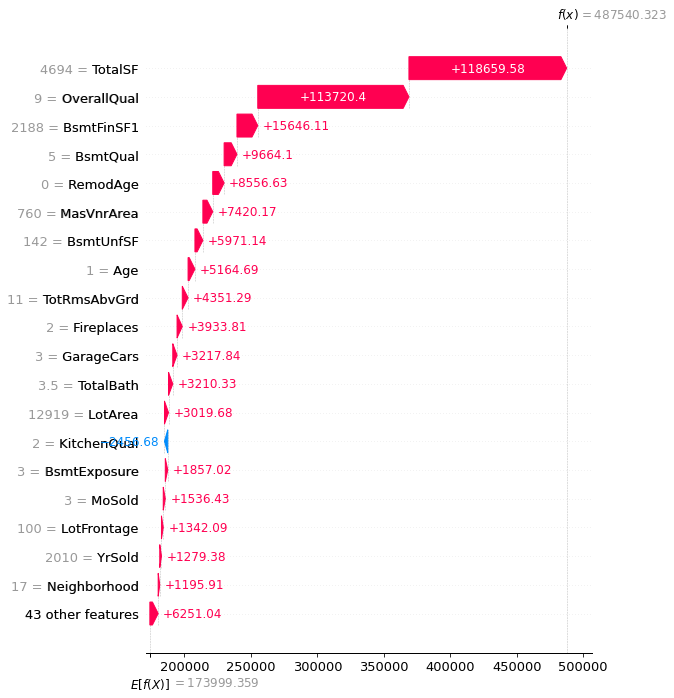

<IPython.core.display.Javascript object>

In [123]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the first instance in the dataset
instance_index = 576

# Get the SHAP values for the specified instance in X_train
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the instance
# A waterfall plot helps visualize the contribution of each feature to the final prediction for the instance
shap.plots.waterfall(shap_values_instance[0],max_display=20)



In [117]:
# Check the current value of the KitchenQual variable for index 576
current_value = X_train.loc[576, 'KitchenQual']
print("Current value of KitchenQual for index 576:", current_value)


Current value of KitchenQual for index 576: 4


<IPython.core.display.Javascript object>

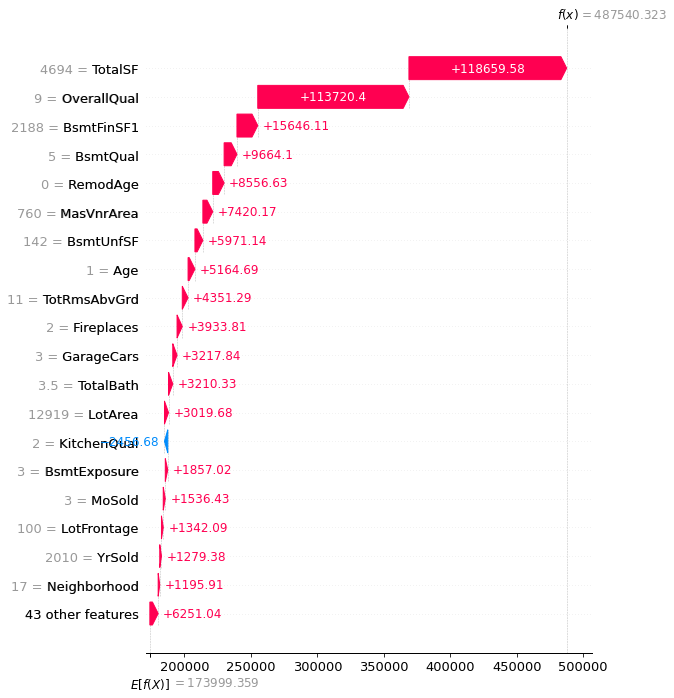

<IPython.core.display.Javascript object>

In [122]:
# Modify the KitchenQual variable for the specified instance
X_train.loc[576, 'KitchenQual'] = 2

# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the modified instance
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the modified instance
shap.plots.waterfall(shap_values_instance[0],max_display=20)


In [119]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.Explainer(best_rf, X_train)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X_train)

# Extract the SHAP values for index 576
shap_values_576 = shap_values[576]

# Print the SHAP values for index 576
print("SHAP values for index 576:\n", shap_values_576)


 99%|===================| 2026/2046 [01:17<00:00]        

SHAP values for index 576:
 .values =
array([ 9.82955448e+01,  1.34209315e+03,  3.01967541e+03,  0.00000000e+00,
        1.46812296e+00,  6.29152090e+02,  7.19294114e+01,  0.00000000e+00,
        5.45858369e+01, -3.34419152e+01,  1.19590949e+03,  4.85319167e+01,
        0.00000000e+00,  9.24639214e+01, -1.79395598e+02,  1.13720404e+05,
       -7.21274074e+02,  7.52177488e+01,  0.00000000e+00, -5.09623397e+01,
       -2.07011125e+01,  1.04282848e+03,  7.42016524e+03,  9.72142739e+00,
        6.01496602e+02,  9.66409558e+03,  1.40458089e+00,  1.85702066e+03,
        1.56461135e+04,  1.80128583e+01,  5.97114000e+03,  5.26554413e-01,
        1.07509089e+03,  7.32498170e+01,  6.00242390e+00,  4.54900861e+02,
       -8.34713107e+01,  6.35085319e+02,  7.60617334e+02,  1.46204428e+01,
       -2.45667809e+03,  4.35129119e+03,  2.63169675e+01,  3.93381105e+03,
        5.69160899e+02,  2.98832303e+02,  3.21784129e+03,  3.29935343e+01,
        2.75751417e+01,  2.85888432e+01,  1.53642837e+03,  1.2

<IPython.core.display.Javascript object>

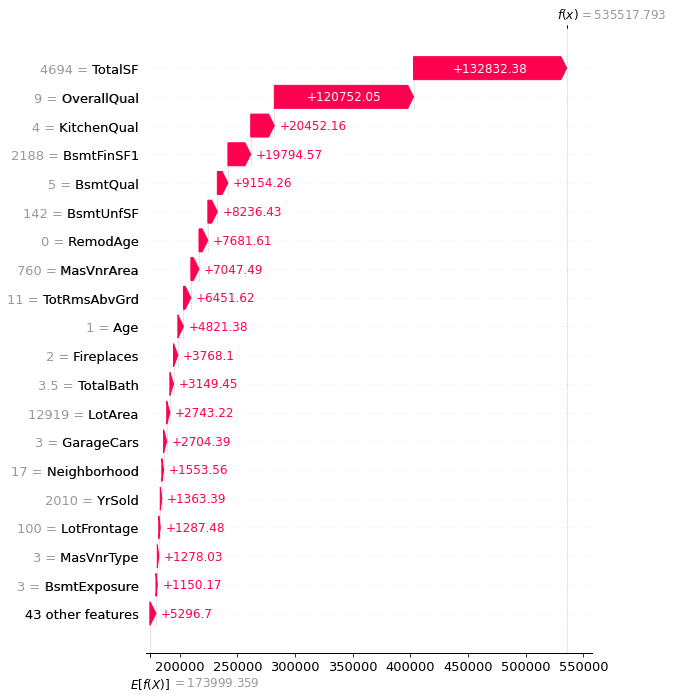

<IPython.core.display.Javascript object>

In [154]:
# Modify the KitchenQual variable for the specified instance
X_train.loc[576, 'KitchenQual'] = 4

# Create a SHAP explainer for the RandomForest model
explainer = shap.TreeExplainer(best_rf, X_train)

# Calculate SHAP values for the modified instance
shap_values_instance = explainer(X_train.iloc[instance_index:instance_index + 1, :])

# Plot the SHAP values as a waterfall plot for the modified instance
shap.plots.waterfall(shap_values_instance[0],max_display=20)


In [121]:
shap_values_df.loc[576, :]

MSZoning              99.582699
LotFrontage         1287.480317
LotArea             2743.222871
Street                      0.0
Alley                  0.727935
LotShape             505.242714
LandContour          165.065269
Utilities                   0.0
LotConfig            101.407864
LandSlope            -46.685837
Neighborhood        1553.558269
Condition1            42.531166
Condition2                  0.0
BldgType              86.221026
HouseStyle          -223.745559
OverallQual       120752.049701
OverallCond         -907.636233
RoofStyle              49.33386
RoofMatl                    0.0
Exterior1st          -36.629502
Exterior2nd          -18.323466
MasVnrType          1278.026245
MasVnrArea          7047.492213
ExterCond             13.659541
Foundation           540.302061
BsmtQual            9154.263646
BsmtCond               1.883858
BsmtExposure        1150.167237
BsmtFinSF1         19794.568562
BsmtFinSF2            41.121587
BsmtUnfSF           8236.427277
Heating 

<IPython.core.display.Javascript object>

## Which Neighborhood to Target for Kitchen Remodel

In [155]:
# Create a SHAP explainer for the RandomForest model
explainer = shap.TreeExplainer(best_rf, X_train)

<IPython.core.display.Javascript object>

In [159]:
shap_values = explainer.shap_values(X_train)

 99%|===================| 2030/2046 [01:17<00:00]        

<IPython.core.display.Javascript object>

In [246]:
# Adding back the Neighborhood Grouping to Shap dataframe
shap_w_neighborhoods = pd.DataFrame(shap_values, columns=X_train.columns)
shap_w_neighborhoods["NeighborhoodGrouped"] = X_train["Neighborhood"]
shap_w_neighborhoods["KitchenQualGrouped"] = X_train["KitchenQual"]

# Moving KitchenQual to First Column
shap_w_neighborhoods.insert(0, "KitchenQual", shap_w_neighborhoods.pop("KitchenQual"))
shap_w_neighborhoods.insert(
    1, "KitchenQualGrouped", shap_w_neighborhoods.pop("KitchenQualGrouped")
)
shap_w_neighborhoods.insert(
    2, "NeighborhoodGrouped", shap_w_neighborhoods.pop("NeighborhoodGrouped")
)

# Grouping by Neighborhood and getting average Kitchen Values
shap_grouped = shap_w_neighborhoods.groupby(by="NeighborhoodGrouped")
shap_grouped_avg = shap_grouped.mean().sort_values(by="KitchenQual", ascending=False)[
    ["KitchenQual"]
]
shap_grouped_avg

,KitchenQual
NeighborhoodGrouped,
17.0,6374.279988
23.0,5355.184216
16.0,4724.019940
25.0,3629.963418
22.0,3367.069840
24.0,2729.093844
0.0,2383.061435
9.0,2017.200886
5.0,1940.742175


<IPython.core.display.Javascript object>

In [201]:
# Top 10
shap_grouped_avg.nlargest(10, "KitchenQual")

,KitchenQual
NeighborhoodGrouped,
17.0,6374.279988
23.0,5355.184216
16.0,4724.019940
25.0,3629.963418
22.0,3367.069840
24.0,2729.093844
0.0,2383.061435
9.0,2017.200886
5.0,1940.742175


<IPython.core.display.Javascript object>

### ^How Do I  Match # with Neighborhood Names^

## Neighborhood Breakdown

In These neighborhoods where kitchens are weighed heavily, we find the lower quality kitchens and target them for renovation showing the client that they specifically have the most to benefit in this specific neighborhood \n specifically the quality 2

In [253]:
# 17
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == 17].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

,KitchenQual,KitchenQualGrouped,NeighborhoodGrouped
2020,2127.475985,3,17.0
635,3732.148332,3,17.0
1572,3145.592828,3,17.0
1549,2658.603094,3,17.0
670,3172.744535,3,17.0
1542,5554.757680,3,17.0
685,2497.079564,3,17.0
686,2432.816092,3,17.0
692,1370.546196,3,17.0
703,3722.682337,3,17.0


<IPython.core.display.Javascript object>

In [254]:
# 23
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == 23].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

,KitchenQual,KitchenQualGrouped,NeighborhoodGrouped
1901,-1725.218943,2,23.0
268,-1225.729107,2,23.0
18,2087.406598,3,23.0
1636,3499.221893,3,23.0
1180,1455.021591,3,23.0
1131,2069.656848,3,23.0
1758,2902.381185,3,23.0
880,3680.624875,3,23.0
811,3268.807547,3,23.0
797,4061.783275,3,23.0


<IPython.core.display.Javascript object>

In [252]:
# 16
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == 16].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

,KitchenQual,KitchenQualGrouped,NeighborhoodGrouped
1712,-1890.937808,2,16.0
105,3305.616082,3,16.0
882,3590.273094,3,16.0
934,2894.632716,3,16.0
995,4253.748955,3,16.0
1170,3246.753488,3,16.0
1192,3186.437719,3,16.0
1281,3684.554716,3,16.0
1310,4636.929746,3,16.0
1447,6038.183573,3,16.0


<IPython.core.display.Javascript object>

In [257]:
# 25
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == 25].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

,KitchenQual,KitchenQualGrouped,NeighborhoodGrouped
1968,-1583.403050,2,25.0
1275,-1974.951676,2,25.0
292,-2961.043544,2,25.0
1953,-1198.663912,2,25.0
1609,7578.190796,3,25.0
1269,3635.628064,3,25.0
1212,8361.079742,3,25.0
1095,2759.571565,3,25.0
607,2349.455498,3,25.0
407,3459.949600,3,25.0


<IPython.core.display.Javascript object>

In [256]:
# 22
shap_w_neighborhoods[shap_w_neighborhoods["NeighborhoodGrouped"] == 22].iloc[
    :, 0:3
].sort_values("KitchenQualGrouped")

,KitchenQual,KitchenQualGrouped,NeighborhoodGrouped
1962,-1939.683498,2,22.0
519,-1094.310575,2,22.0
701,-1526.367213,2,22.0
1687,-1353.200025,2,22.0
52,1485.986320,3,22.0
1392,4119.692516,3,22.0
1373,2479.865433,3,22.0
1295,1853.288026,3,22.0
1293,2105.454931,3,22.0
1272,4623.520913,3,22.0


<IPython.core.display.Javascript object>